In [21]:
import os
import operator

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from clickhouse_driver import Client

client = Client('localhost', database="thesisoptimaldb")

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)

exp_df["configuration_profile"] = ""
exp_df.loc[(exp_df["exp_id"].str.startswith("thesis_group_combined_")), "configuration_profile"]  = "Default"
exp_df.loc[~(exp_df["exp_id"].str.startswith("thesis_group_combined_")), "configuration_profile"] = "Modified"

print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

8
thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https
thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https
thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https
thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https
thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_h

,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0mbps,256,0,8,5,140,30,140,140,...,250,60,4,150,1,True,False,True,False,Default
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,0mbps,256,0,8,5,140,30,140,140,...,250,60,4,150,1,True,True,True,False,Default
2,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,100mbps,256,0,8,5,140,30,140,140,...,250,60,4,150,1,True,False,True,True,Default
3,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,100mbps,256,0,8,5,140,30,140,140,...,250,60,4,150,1,True,True,True,True,Default
4,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,8,5,140,30,140,140,...,50,5,2,5,1,True,False,True,False,Modified
5,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,8,5,140,30,140,140,...,50,5,2,5,1,True,True,True,False,Modified
6,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,50,5,2,5,1,True,False,True,True,Modified
7,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,50,5,2,5,1,True,True,True,True,Modified


In [3]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))
proxy_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("proxy"))
originserver_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("originserver"))

attacker_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("attacker"))
client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))
originserver_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("originserver"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{proxy_dnids=}")
print(f"{originserver_dnids=}")
print(f"{attacker_node_ids=}")
print(f"{client_node_ids=}")
print(f"{originserver_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93}
attacker_dnids={1, 37, 73, 13, 49, 85, 25, 61}
proxy_dnids={35, 71, 11, 47, 83, 23, 59, 95}
originserver_dnids={34, 70, 10, 46, 82, 22, 58, 94}
attacker_node_ids={1}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
originserver_node_ids={10}
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 20.3 ms


In [4]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' '' 'bad_gateway']


,exp_id,trial,observer_id,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client1,1,content,0.000000,0.374155,0.000000,0.000000,0.374155,...,250,60,4,150,1,True,False,True,False,Default
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client1,2,content,0.389228,0.482835,0.389228,0.389228,0.482835,...,250,60,4,150,1,True,False,True,False,Default
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client1,3,content,0.484991,0.581378,0.484991,0.484991,0.581378,...,250,60,4,150,1,True,False,True,False,Default
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client1,4,content,0.583750,0.676105,0.583750,0.583750,0.676105,...,250,60,4,150,1,True,False,True,False,Default
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client1,5,content,0.678485,0.765098,0.678485,0.678485,0.765098,...,250,60,4,150,1,True,False,True,False,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460633,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,711951,content,125.473589,125.526408,125.473589,125.473589,125.526408,...,50,5,2,5,1,True,True,True,True,Modified
460634,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,711952,content,125.527217,125.580026,125.527217,125.527217,125.580026,...,50,5,2,5,1,True,True,True,True,Modified
460635,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,711953,content,125.580866,125.633697,125.580866,125.580866,125.633697,...,50,5,2,5,1,True,True,True,True,Modified
460636,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,711954,content,125.634524,125.687322,125.634524,125.634524,125.687322,...,50,5,2,5,1,True,True,True,True,Modified


In [5]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 1.08 s, sys: 171 ms, total: 1.25 s
Wall time: 1.69 s


,exp_id,observe_timestamp,trial,observer_id,message_marker,coap_retransmitted
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.000000,1,client1,1,False
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.389228,1,client1,2,False
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.484991,1,client1,3,False
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.583750,1,client1,4,False
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.678485,1,client1,5,False
...,...,...,...,...,...,...
461767,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.473589,5,client8,711951,False
461768,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.527217,5,client8,711952,False
461769,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.580866,5,client8,711953,False
461770,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.634524,5,client8,711954,False


In [6]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content' 'bad_gateway']
CPU times: user 1.32 s, sys: 1.44 s, total: 2.75 s
Wall time: 3.24 s


,exp_id,observe_timestamp,trial,observer_id,message_marker,response_code,successful_message
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.374155,1,client1,1,content,True
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.482835,1,client1,2,content,True
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.581378,1,client1,3,content,True
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.676105,1,client1,4,content,True
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,0.765098,1,client1,5,content,True
...,...,...,...,...,...,...,...
460320,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.472758,5,client8,711950,content,True
460321,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.526408,5,client8,711951,content,True
460322,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.580026,5,client8,711952,content,True
460323,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.633697,5,client8,711953,content,True


In [7]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 16.5 ms, sys: 861 µs, total: 17.3 ms
Wall time: 99.1 ms


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,originserver,cpu_utilization,2.176429,0.5,8.9,0mbps,256,0,...,250,60,4,150,1,True,False,True,False,Default
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,cpu_utilization,7.100000,0.5,23.4,0mbps,256,0,...,250,60,4,150,1,True,False,True,False,Default
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,originserver,memory_utilization,257.335537,239.0,261.0,0mbps,256,0,...,250,60,4,150,1,True,False,True,False,Default
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,memory_utilization,488.613223,241.0,512.0,0mbps,256,0,...,250,60,4,150,1,True,False,True,False,Default
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,2,originserver,cpu_utilization,2.179286,0.4,10.7,0mbps,256,0,...,250,60,4,150,1,True,False,True,False,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,proxy,memory_utilization,3856.508333,268.0,6450.0,100mbps,256,0,...,50,5,2,5,1,True,True,True,True,Modified
156,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,originserver,cpu_utilization,5.586429,0.4,23.4,100mbps,256,0,...,50,5,2,5,1,True,True,True,True,Modified
157,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,cpu_utilization,16.064286,0.4,91.9,100mbps,256,0,...,50,5,2,5,1,True,True,True,True,Modified
158,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,originserver,memory_utilization,274.095868,251.0,301.0,100mbps,256,0,...,50,5,2,5,1,True,True,True,True,Modified


In [8]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 2.59 s, sys: 14.8 ms, total: 2.61 s
Wall time: 2.62 s


,exp_id,trial,observer_id,num_messages,num_successful_messages,mean_rps,max_num_retransmissions,total_num_retransmissions,stddev_rtt_ms,min_rtt_ms,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client1,1524,1523,12.691667,0,0,7.789335,74.710131,...,250,60,4,150,1,reuse-connections,coap,https,no-attacker,Default
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client2,1529,1528,12.733333,0,0,1.484848,74.699879,...,250,60,4,150,1,reuse-connections,coap,https,no-attacker,Default
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client3,1530,1529,12.741667,0,0,1.298282,74.942112,...,250,60,4,150,1,reuse-connections,coap,https,no-attacker,Default
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client4,1532,1531,12.758333,0,0,1.224382,74.769974,...,250,60,4,150,1,reuse-connections,coap,https,no-attacker,Default
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client5,1530,1529,12.741667,0,0,1.333669,74.928999,...,250,60,4,150,1,reuse-connections,coap,https,no-attacker,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client4,1574,1571,13.091667,2,6,406.806386,51.426888,...,50,5,2,5,1,reuse-connections,dtls,https,attacker,Modified
316,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client5,1577,1574,13.116667,2,7,344.336472,51.604986,...,50,5,2,5,1,reuse-connections,dtls,https,attacker,Modified
317,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client6,1575,1570,13.083333,2,7,349.602936,51.599979,...,50,5,2,5,1,reuse-connections,dtls,https,attacker,Modified
318,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client7,1576,1573,13.108333,2,8,430.741619,51.572084,...,50,5,2,5,1,reuse-connections,dtls,https,attacker,Modified


In [9]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

value_map_replacement = {
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    False: "CoAP",
    "dtls": "CoAPS",
    True: "CoAPS",
  },
  "reuse_connections": {
    "reuse-connections": "Reuse Connections",
    True: "Reuse Connections",
    "no-connection-reuse": "No Connection Reuse",
    False: "No Connection Reuse",
  },
  "run_attacker": {
    "attacker": "With Attacker",
    True: "With Attacker",
    "no-attacker": "Without Attacker",
    False: "Without Attacker",
  },
  "response_code": {
    "bad_gateway": "Bad Gateway",
    "content": "Content",
  },
}

client_rps_df.replace(value_map_replacement, inplace=True)
metric_df.replace(value_map_replacement, inplace=True)

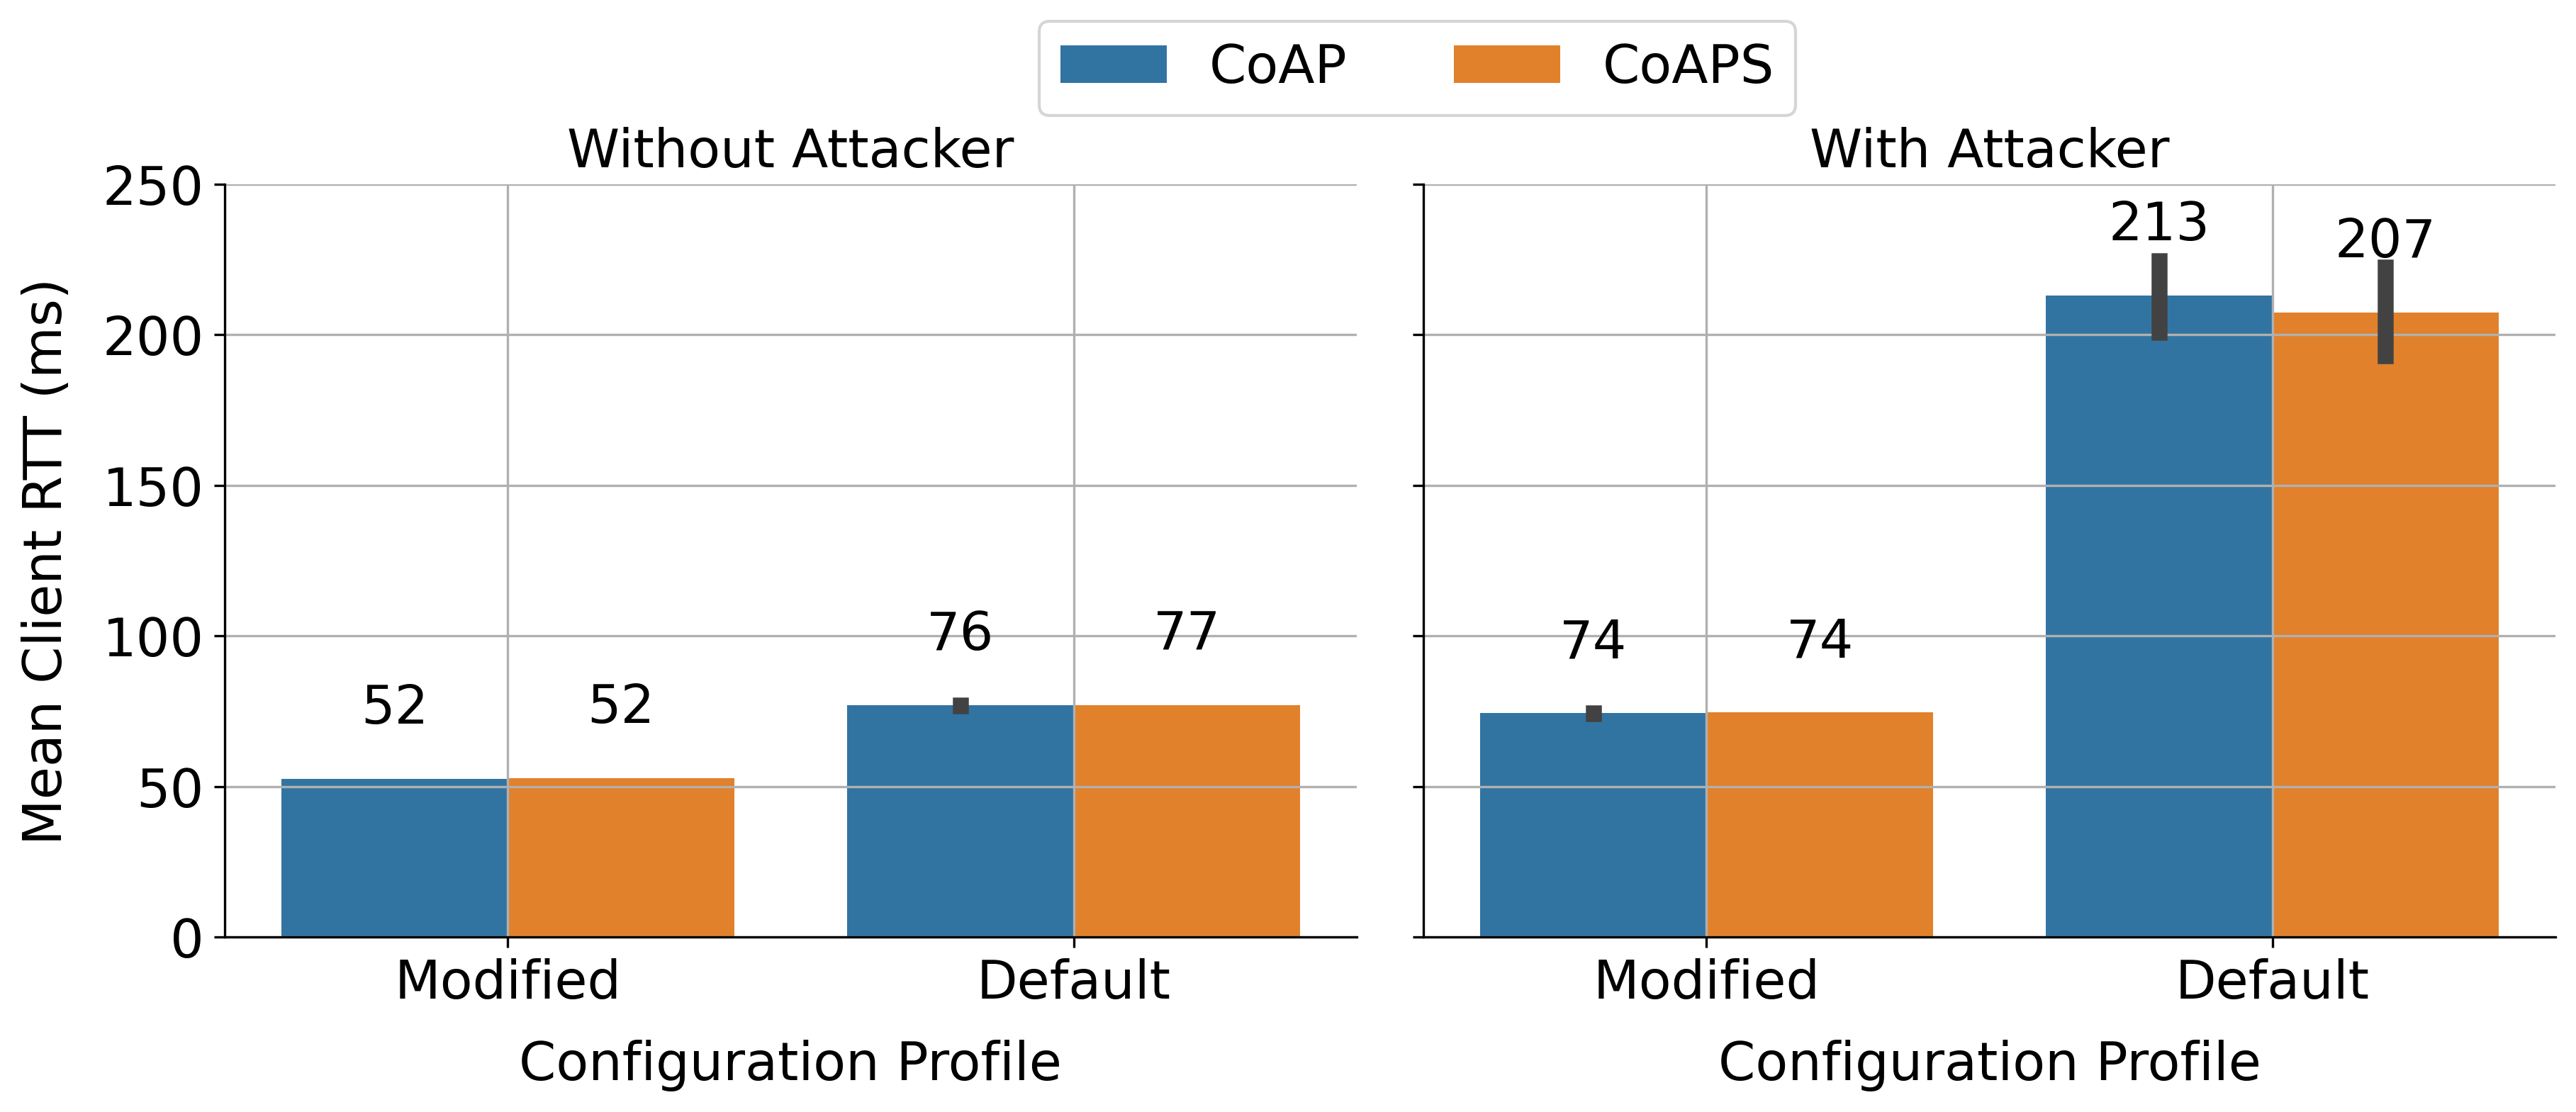

CPU times: user 1.31 s, sys: 235 ms, total: 1.54 s
Wall time: 1.24 s


,exp_id,trial,observer_id,num_messages,num_successful_messages,mean_rps,max_num_retransmissions,total_num_retransmissions,stddev_rtt_ms,min_rtt_ms,...,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile,active_time_sec
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client1,1524,1523,12.691667,0,0,7.789335,74.710131,...,60,4,150,1,Reuse Connections,CoAP,https,Without Attacker,Default,119.070271
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client2,1529,1528,12.733333,0,0,1.484848,74.699879,...,60,4,150,1,Reuse Connections,CoAP,https,Without Attacker,Default,119.119291
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client3,1530,1529,12.741667,0,0,1.298282,74.942112,...,60,4,150,1,Reuse Connections,CoAP,https,Without Attacker,Default,119.073642
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client4,1532,1531,12.758333,0,0,1.224382,74.769974,...,60,4,150,1,Reuse Connections,CoAP,https,Without Attacker,Default,119.088945
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,client5,1530,1529,12.741667,0,0,1.333669,74.928999,...,60,4,150,1,Reuse Connections,CoAP,https,Without Attacker,Default,119.008661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client4,1574,1571,13.091667,2,6,406.806386,51.426888,...,5,2,5,1,Reuse Connections,CoAPS,https,With Attacker,Modified,118.927251
316,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client5,1577,1574,13.116667,2,7,344.336472,51.604986,...,5,2,5,1,Reuse Connections,CoAPS,https,With Attacker,Modified,118.956966
317,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client6,1575,1570,13.083333,2,7,349.602936,51.599979,...,5,2,5,1,Reuse Connections,CoAPS,https,With Attacker,Modified,118.848716
318,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client7,1576,1573,13.108333,2,8,430.741619,51.572084,...,5,2,5,1,Reuse Connections,CoAPS,https,With Attacker,Modified,118.933755


In [40]:
%%time

### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="mean_rtt_ms",
  hue="run_proxy_with_dtls",
  col="run_attacker",
  order=["Modified", "Default"],
  aspect=1.25,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Configuration Profile", labelpad=10)
g.set_ylabels("Mean Client RTT (ms)", labelpad=10)
g.set_titles(
  template="{col_name}",
)

g.set(
  yticks=np.arange(0,251,50),
)

axes = [ g.axes[0, i] for i in range(2) ]
for i, ax in enumerate(axes):
  ax.grid(True, axis="both")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=15)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.461, 1.07),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

df

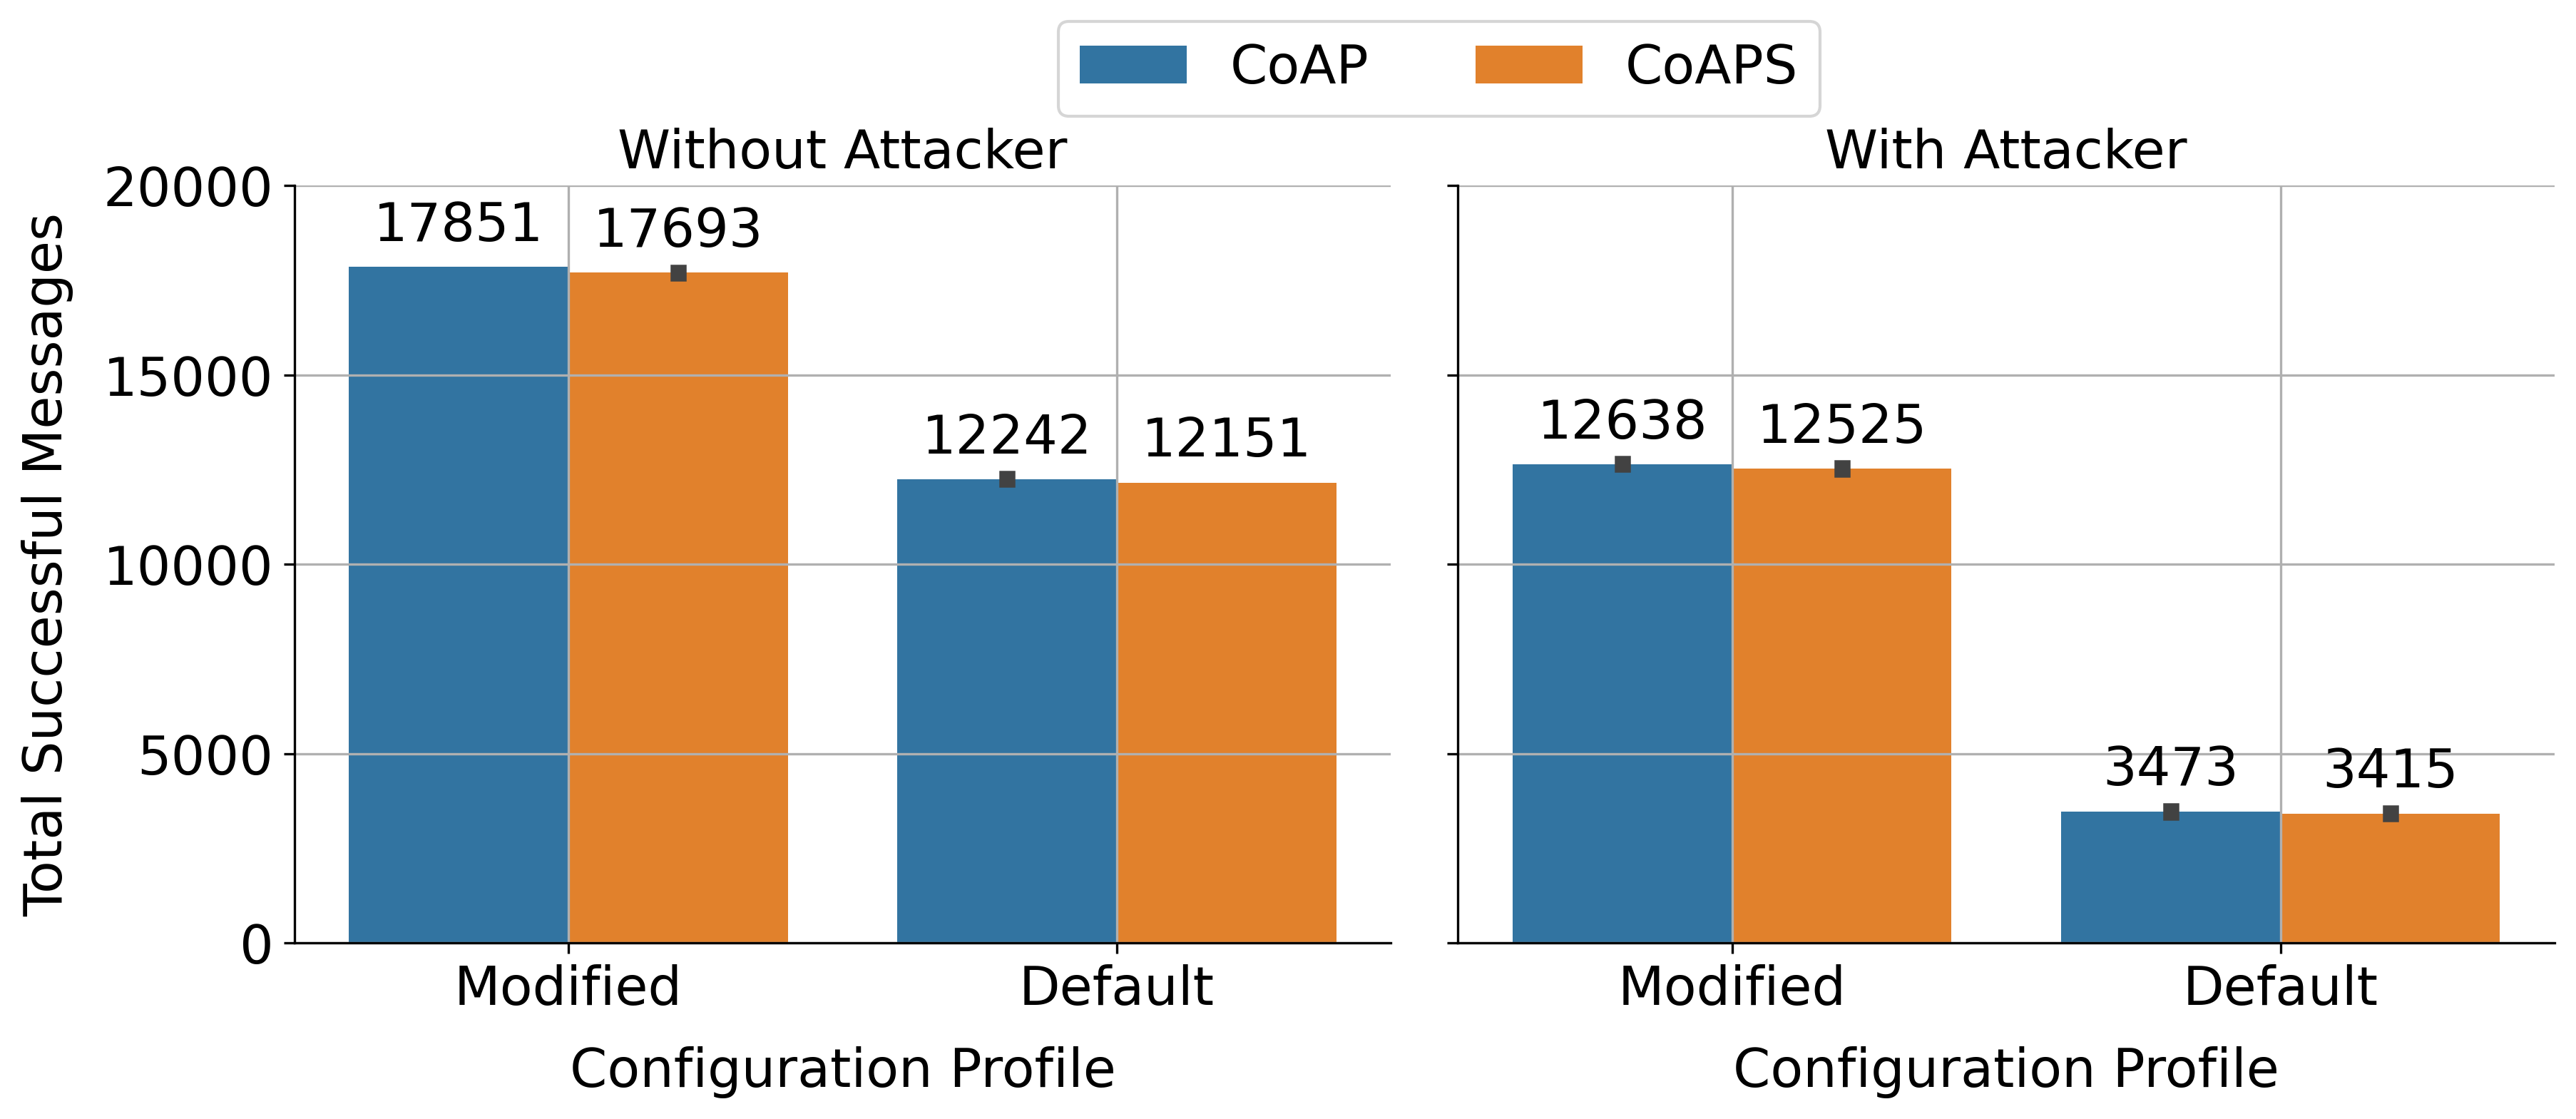

,exp_id,run_proxy_with_dtls,num_clients,num_proxy_connections,mean_total_successful_messages,mean_successful_messages_per_client
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,CoAP,8,250,12242.6,1530.325
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,CoAPS,8,250,12151.4,1518.925
2,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,CoAP,8,250,3473.8,434.225
3,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,CoAPS,8,250,3415.4,426.925
4,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,CoAP,8,50,17851.0,2231.375
5,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,CoAPS,8,50,17693.4,2211.675
6,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,CoAP,8,50,12638.6,1579.825
7,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,CoAPS,8,50,12525.4,1565.675


In [50]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "num_proxy_connections", "configuration_profile", "run_attacker", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  col="run_attacker",
  order=["Modified", "Default"],
  aspect=1.25,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Configuration Profile", labelpad=10)
g.set_ylabels("Total Successful Messages", labelpad=10)
g.set_titles(
  template="{col_name}",
)

g.set(
  yticks=np.arange(0,20_001,5_000),
)

axes = [ g.axes[0, i] for i in range(2) ]
for ax in axes:
  ax.grid(True, axis="both")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.47, 1.07),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "num_proxy_connections"])
  .agg(
    mean_total_successful_messages=("total_successful_messages", "mean"),
  )
  .reset_index()
)
_df["mean_successful_messages_per_client"] = _df["mean_total_successful_messages"] / _df["num_clients"]
_df

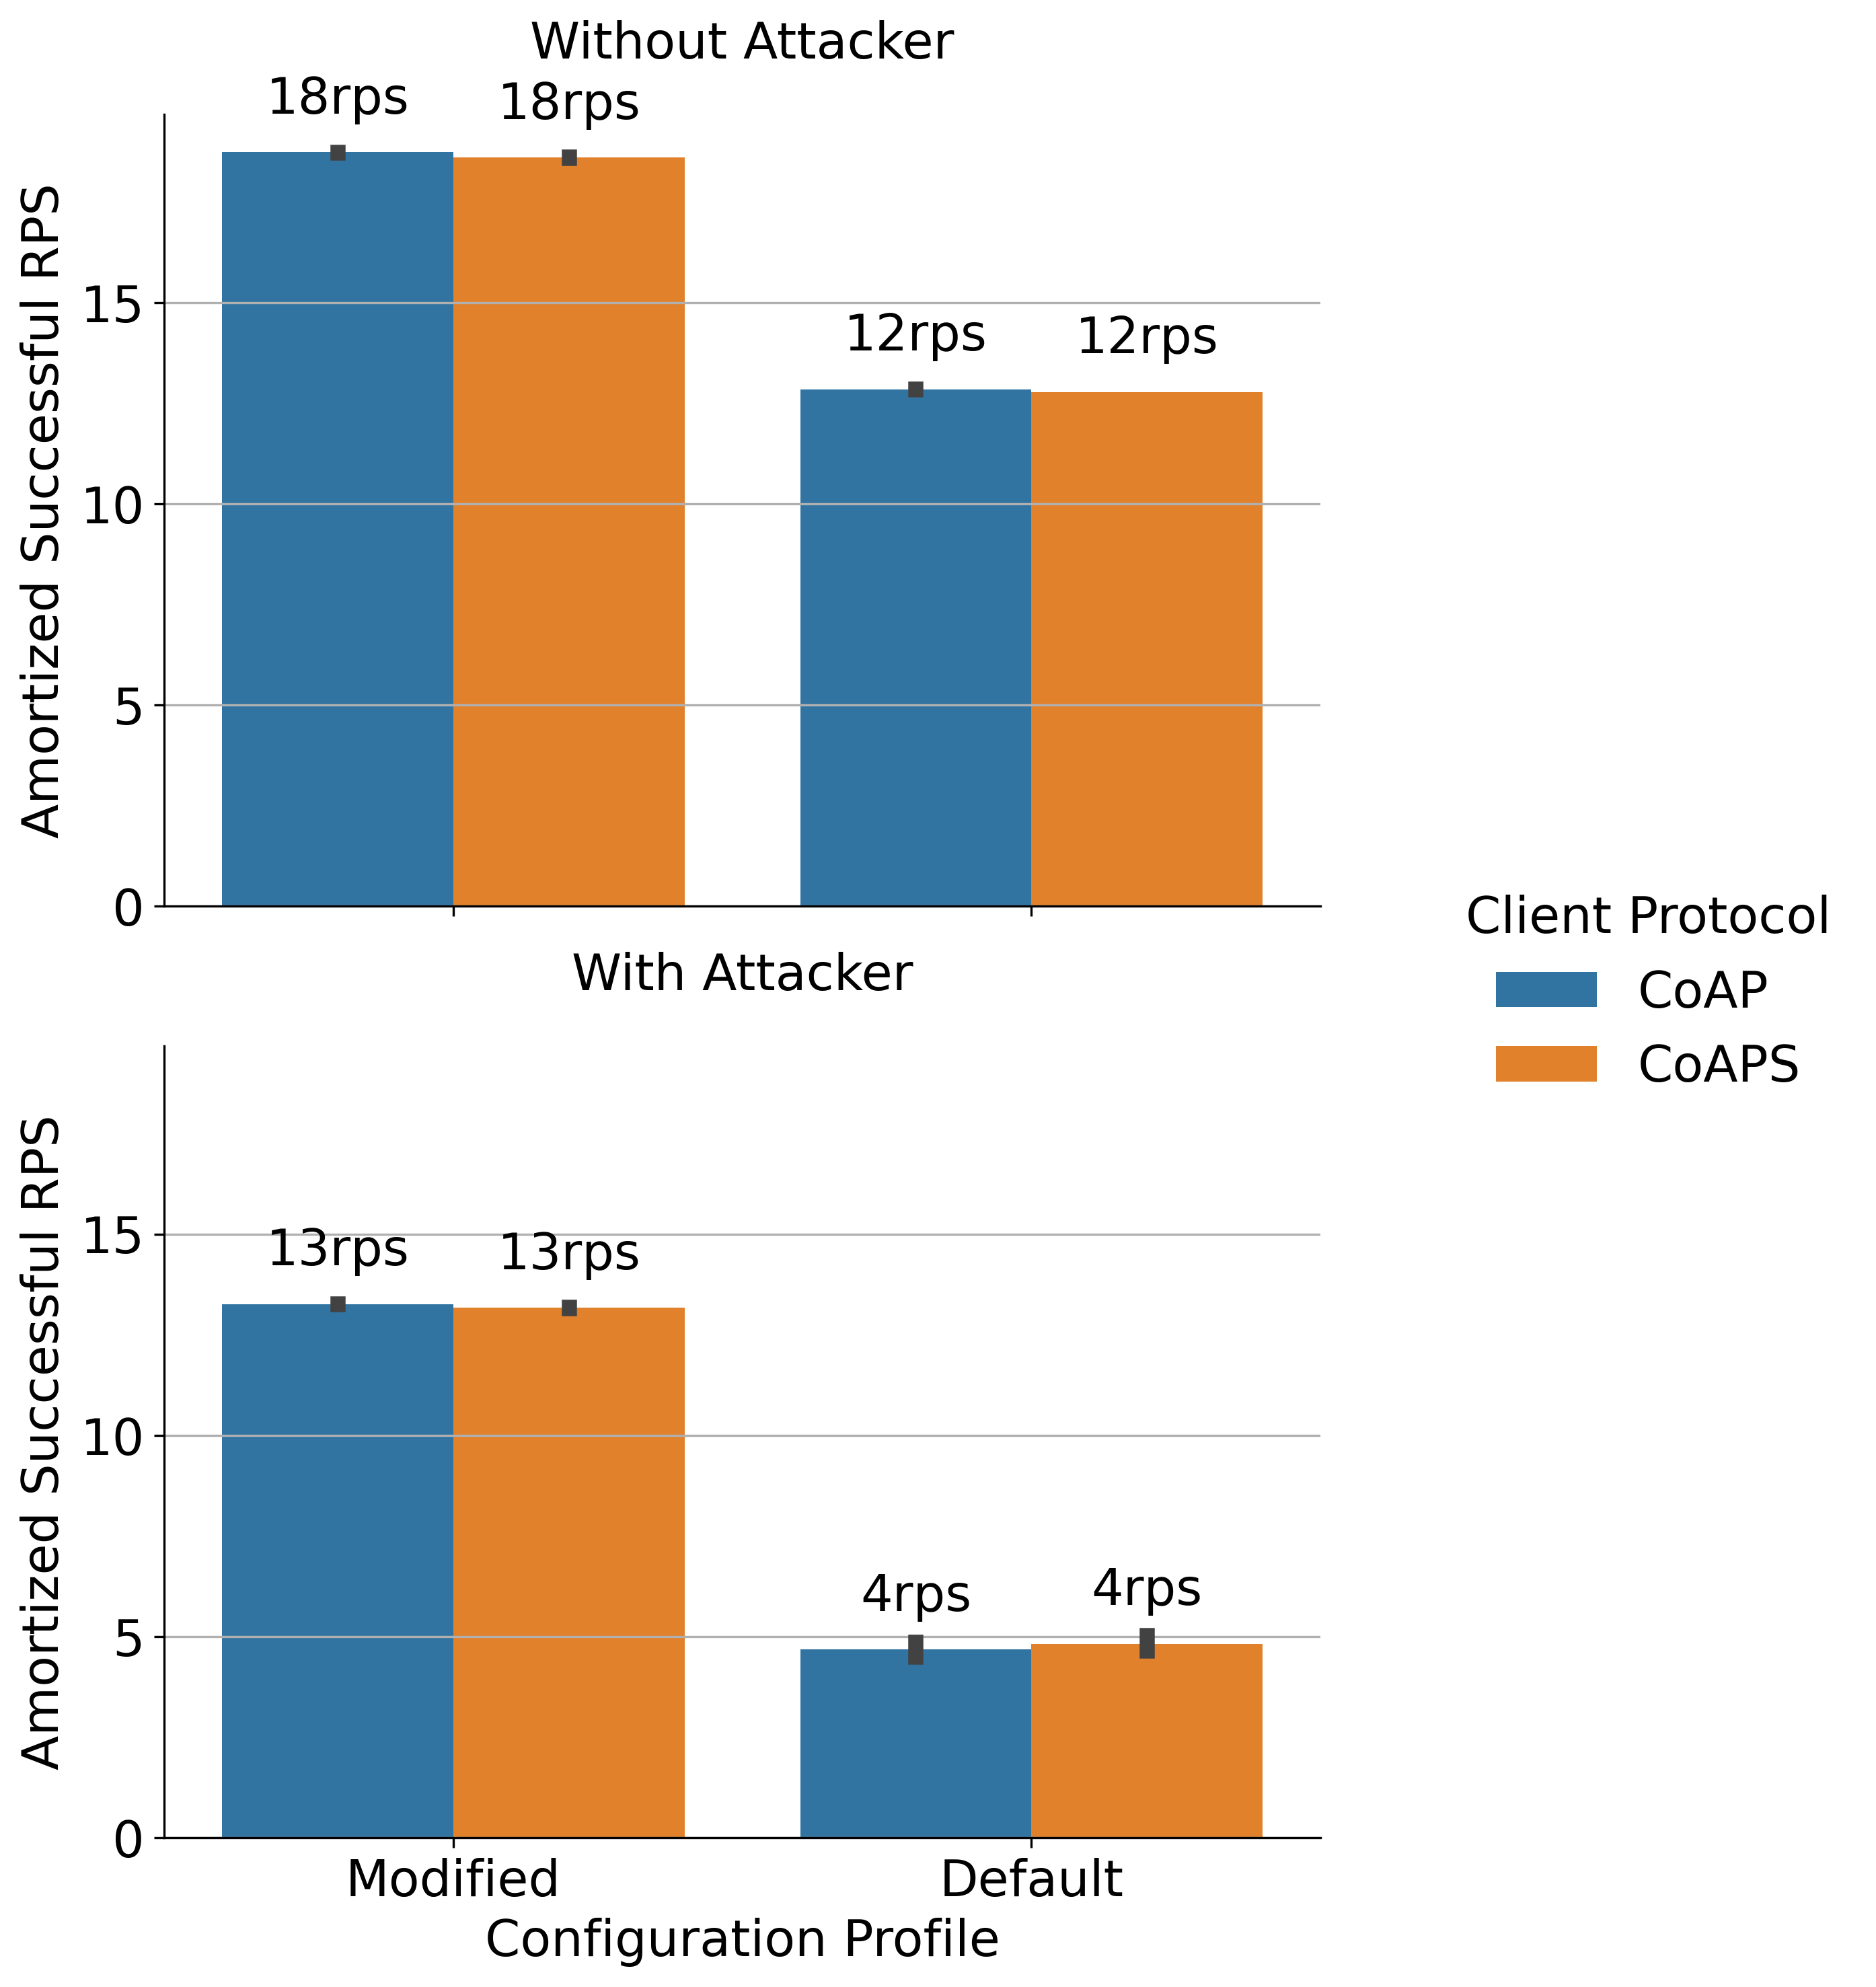

,exp_id,run_proxy_with_dtls,num_clients,num_proxy_connections,mean_amortized_successful_rps,mean_amortized_rps_messages_per_client
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,CoAP,8,250,12.847165,1.605896
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,CoAPS,8,250,12.776812,1.597101
2,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,CoAP,8,250,4.678746,0.584843
3,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,CoAPS,8,250,4.818152,0.602269
4,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,CoAP,8,50,18.729825,2.341228
5,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,CoAPS,8,50,18.600421,2.325053
6,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,CoAP,8,50,13.260224,1.657528
7,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,CoAPS,8,50,13.166996,1.645875


In [12]:
g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  row="run_attacker",
  order=["Modified", "Default"],
  aspect=1.5,
)

g.set_xlabels("Configuration Profile")
g.set_ylabels("Amortized Successful RPS")
g.set_titles(
  template="{row_name}",
  pad=20,
)
g.legend.set_title("Client Protocol")

axes = [ g.axes[i, 0] for i in range(2) ]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%drps", padding=10)

plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "num_proxy_connections"])
  .agg(
    mean_amortized_successful_rps=("amortized_successful_rps", "mean"),
  )
  .reset_index()
)
_df["mean_amortized_rps_messages_per_client"] = _df["mean_amortized_successful_rps"] / _df["num_clients"]
_df

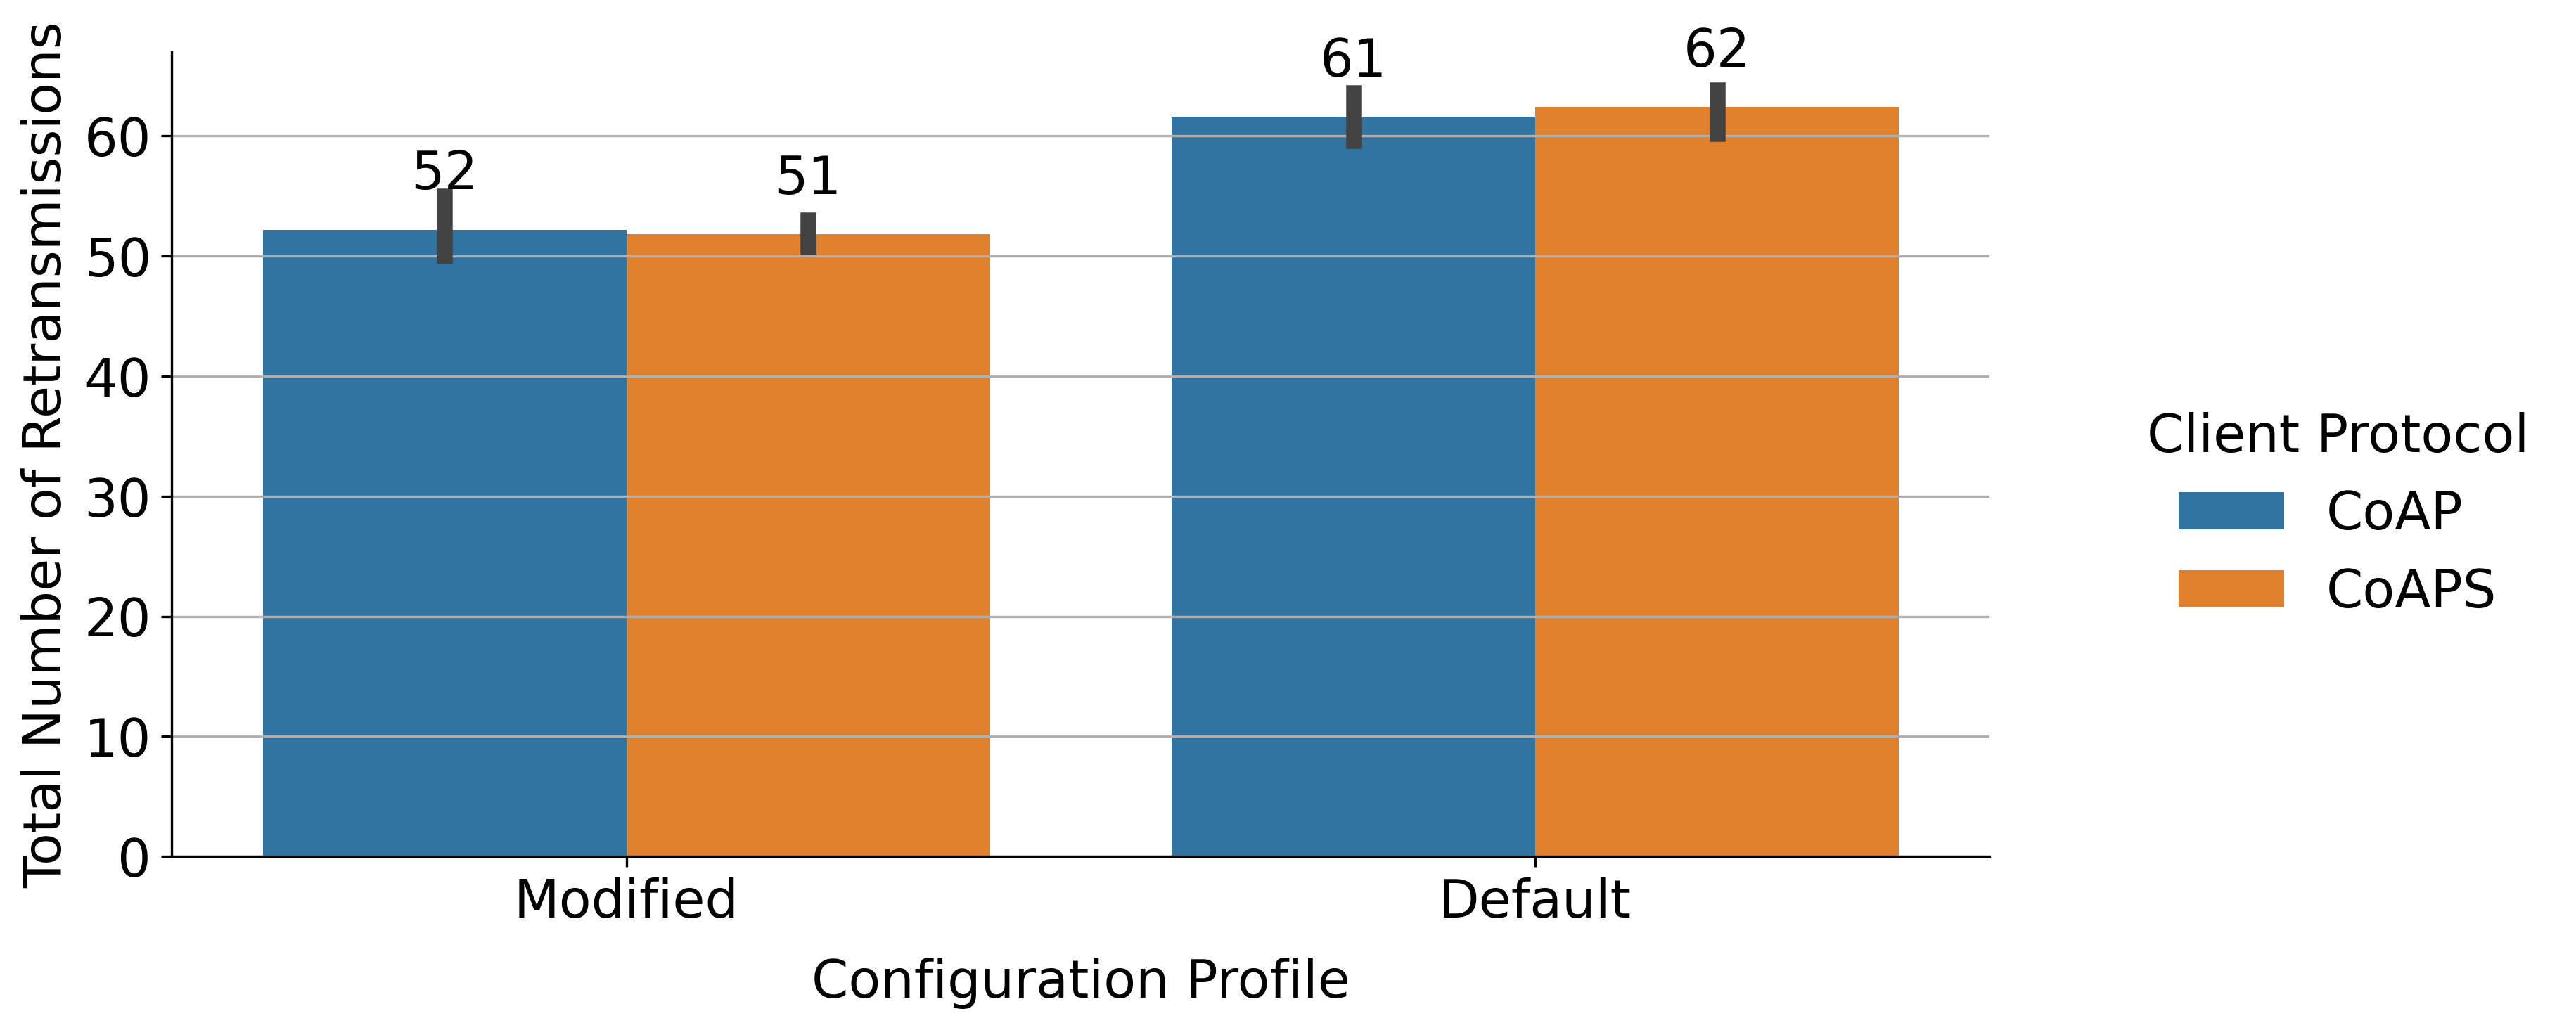

,exp_id,trial,num_clients,run_proxy_with_dtls,num_proxy_connections,configuration_profile,run_attacker,total_num_retransmissions
10,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,8,CoAP,250,Default,With Attacker,62
11,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,2,8,CoAP,250,Default,With Attacker,61
12,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,3,8,CoAP,250,Default,With Attacker,62
13,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,4,8,CoAP,250,Default,With Attacker,58
14,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,8,CoAP,250,Default,With Attacker,65
15,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,1,8,CoAPS,250,Default,With Attacker,58
16,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,2,8,CoAPS,250,Default,With Attacker,64
17,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,3,8,CoAPS,250,Default,With Attacker,63
18,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,4,8,CoAPS,250,Default,With Attacker,64
19,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,5,8,CoAPS,250,Default,With Attacker,63


In [13]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "run_proxy_with_dtls", "num_proxy_connections", "configuration_profile", "run_attacker"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)
df = df[df["run_attacker"] == "With Attacker"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="total_num_retransmissions",
  hue="run_proxy_with_dtls",
  order=["Modified", "Default"],
  aspect=2,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Configuration Profile", labelpad=10)
g.set_ylabels("Total Number of Retransmissions")

axes = [ g.axes[0, 0] ]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=10)

plt.show()

df[df["total_num_retransmissions"] > 0]

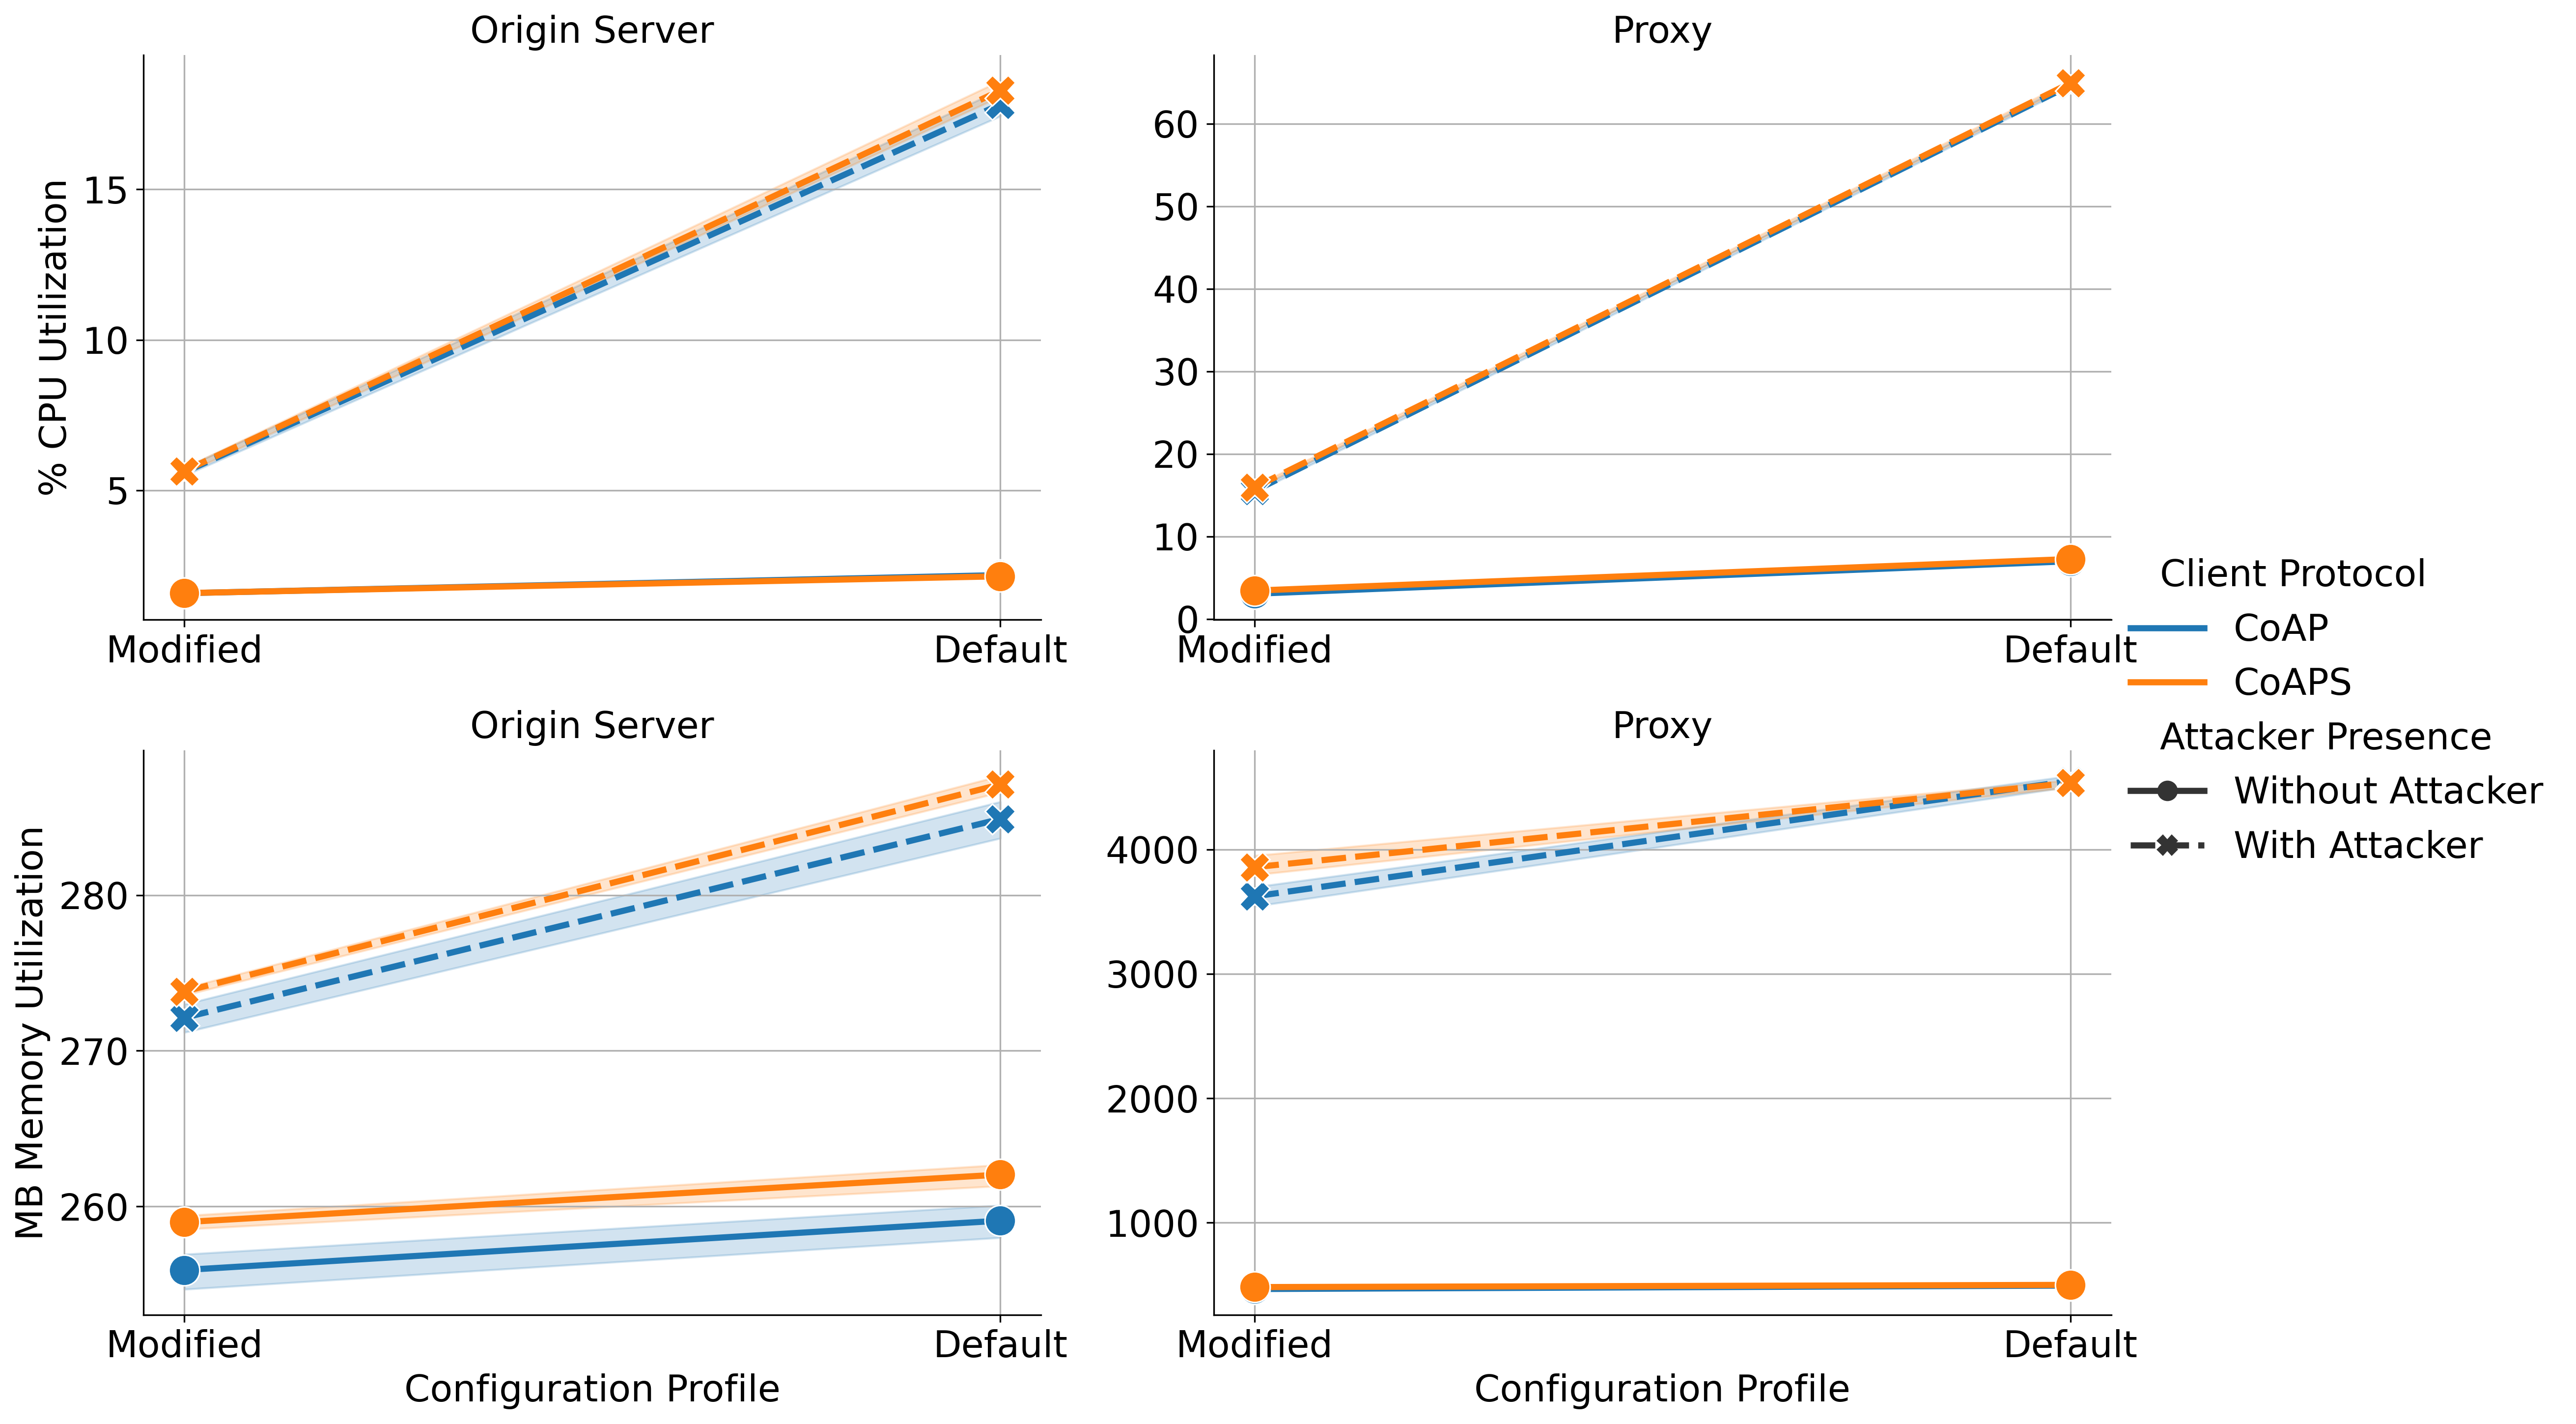

CPU times: user 4.99 s, sys: 525 ms, total: 5.51 s
Wall time: 5.24 s


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,Client Protocol,run_proxy_with_https,Attacker Presence,configuration_profile
80,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,% CPU Utilization,1.538571,0.5,8.2,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAP,True,Without Attacker,Modified
110,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,Origin Server,MB Memory Utilization,259.333884,244.0,261.0,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
103,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,MB Memory Utilization,476.947107,265.0,508.0,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
104,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Origin Server,% CPU Utilization,1.598571,0.4,10.0,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
105,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Proxy,% CPU Utilization,3.441429,0.3,27.8,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,4,Proxy,MB Memory Utilization,4533.022430,248.0,7821.0,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
56,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,Origin Server,% CPU Utilization,17.487143,0.5,38.5,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
57,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,Proxy,% CPU Utilization,65.002857,0.5,99.6,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
58,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,Origin Server,MB Memory Utilization,286.266223,245.0,346.0,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default


In [14]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .rename(columns={
    "run_proxy_with_dtls": "Client Protocol",
    "run_attacker": "Attacker Presence",
  })
  .sort_values(by=["configuration_profile"], ascending=False)
)

g = sns.relplot(
  data=df,
  kind="line",
  x="configuration_profile",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="Client Protocol",
  style="Attacker Presence",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
  aspect=1.5,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Configuration Profile")
g.set_ylabels("Average Metric Value")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

plt.show()

df

In [15]:
(
  df
  .groupby(
    by=["observer_id", "Client Protocol", "Attacker Presence", "configuration_profile", "metric_type"]
  )
  .agg(
    avg_value=("avg_value", "mean")
  )
  .reset_index()
  .sort_values(
    by=["observer_id", "Client Protocol", "Attacker Presence", "configuration_profile", "metric_type"]
  )
  .head(20)
)

,observer_id,Client Protocol,Attacker Presence,configuration_profile,metric_type,avg_value
0,Origin Server,CoAP,With Attacker,Default,% CPU Utilization,17.822857
1,Origin Server,CoAP,With Attacker,Default,MB Memory Utilization,284.895981
2,Origin Server,CoAP,With Attacker,Modified,% CPU Utilization,5.601000
3,Origin Server,CoAP,With Attacker,Modified,MB Memory Utilization,272.128212
4,Origin Server,CoAP,Without Attacker,Default,% CPU Utilization,2.179714
5,Origin Server,CoAP,Without Attacker,Default,MB Memory Utilization,259.083636
6,Origin Server,CoAP,Without Attacker,Modified,% CPU Utilization,1.579143
7,Origin Server,CoAP,Without Attacker,Modified,MB Memory Utilization,255.916808
8,Origin Server,CoAPS,With Attacker,Default,% CPU Utilization,18.284857
9,Origin Server,CoAPS,With Attacker,Default,MB Memory Utilization,287.116389


In [16]:
(
  df
  .groupby(
    by=["observer_id", "Client Protocol", "Attacker Presence", "configuration_profile", "metric_type"]
  )
  .agg(
    avg_value=("avg_value", "mean")
  )
  .reset_index()
  .sort_values(
    by=["observer_id", "Client Protocol", "Attacker Presence", "configuration_profile", "metric_type"]
  )
  .tail(20)
)

,observer_id,Client Protocol,Attacker Presence,configuration_profile,metric_type,avg_value
12,Origin Server,CoAPS,Without Attacker,Default,% CPU Utilization,2.140429
13,Origin Server,CoAPS,Without Attacker,Default,MB Memory Utilization,262.044628
14,Origin Server,CoAPS,Without Attacker,Modified,% CPU Utilization,1.581571
15,Origin Server,CoAPS,Without Attacker,Modified,MB Memory Utilization,258.991522
16,Proxy,CoAP,With Attacker,Default,% CPU Utilization,64.672143
17,Proxy,CoAP,With Attacker,Default,MB Memory Utilization,4552.244173
18,Proxy,CoAP,With Attacker,Modified,% CPU Utilization,15.522286
19,Proxy,CoAP,With Attacker,Modified,MB Memory Utilization,3623.390420
20,Proxy,CoAP,Without Attacker,Default,% CPU Utilization,7.009714
21,Proxy,CoAP,Without Attacker,Default,MB Memory Utilization,493.999669


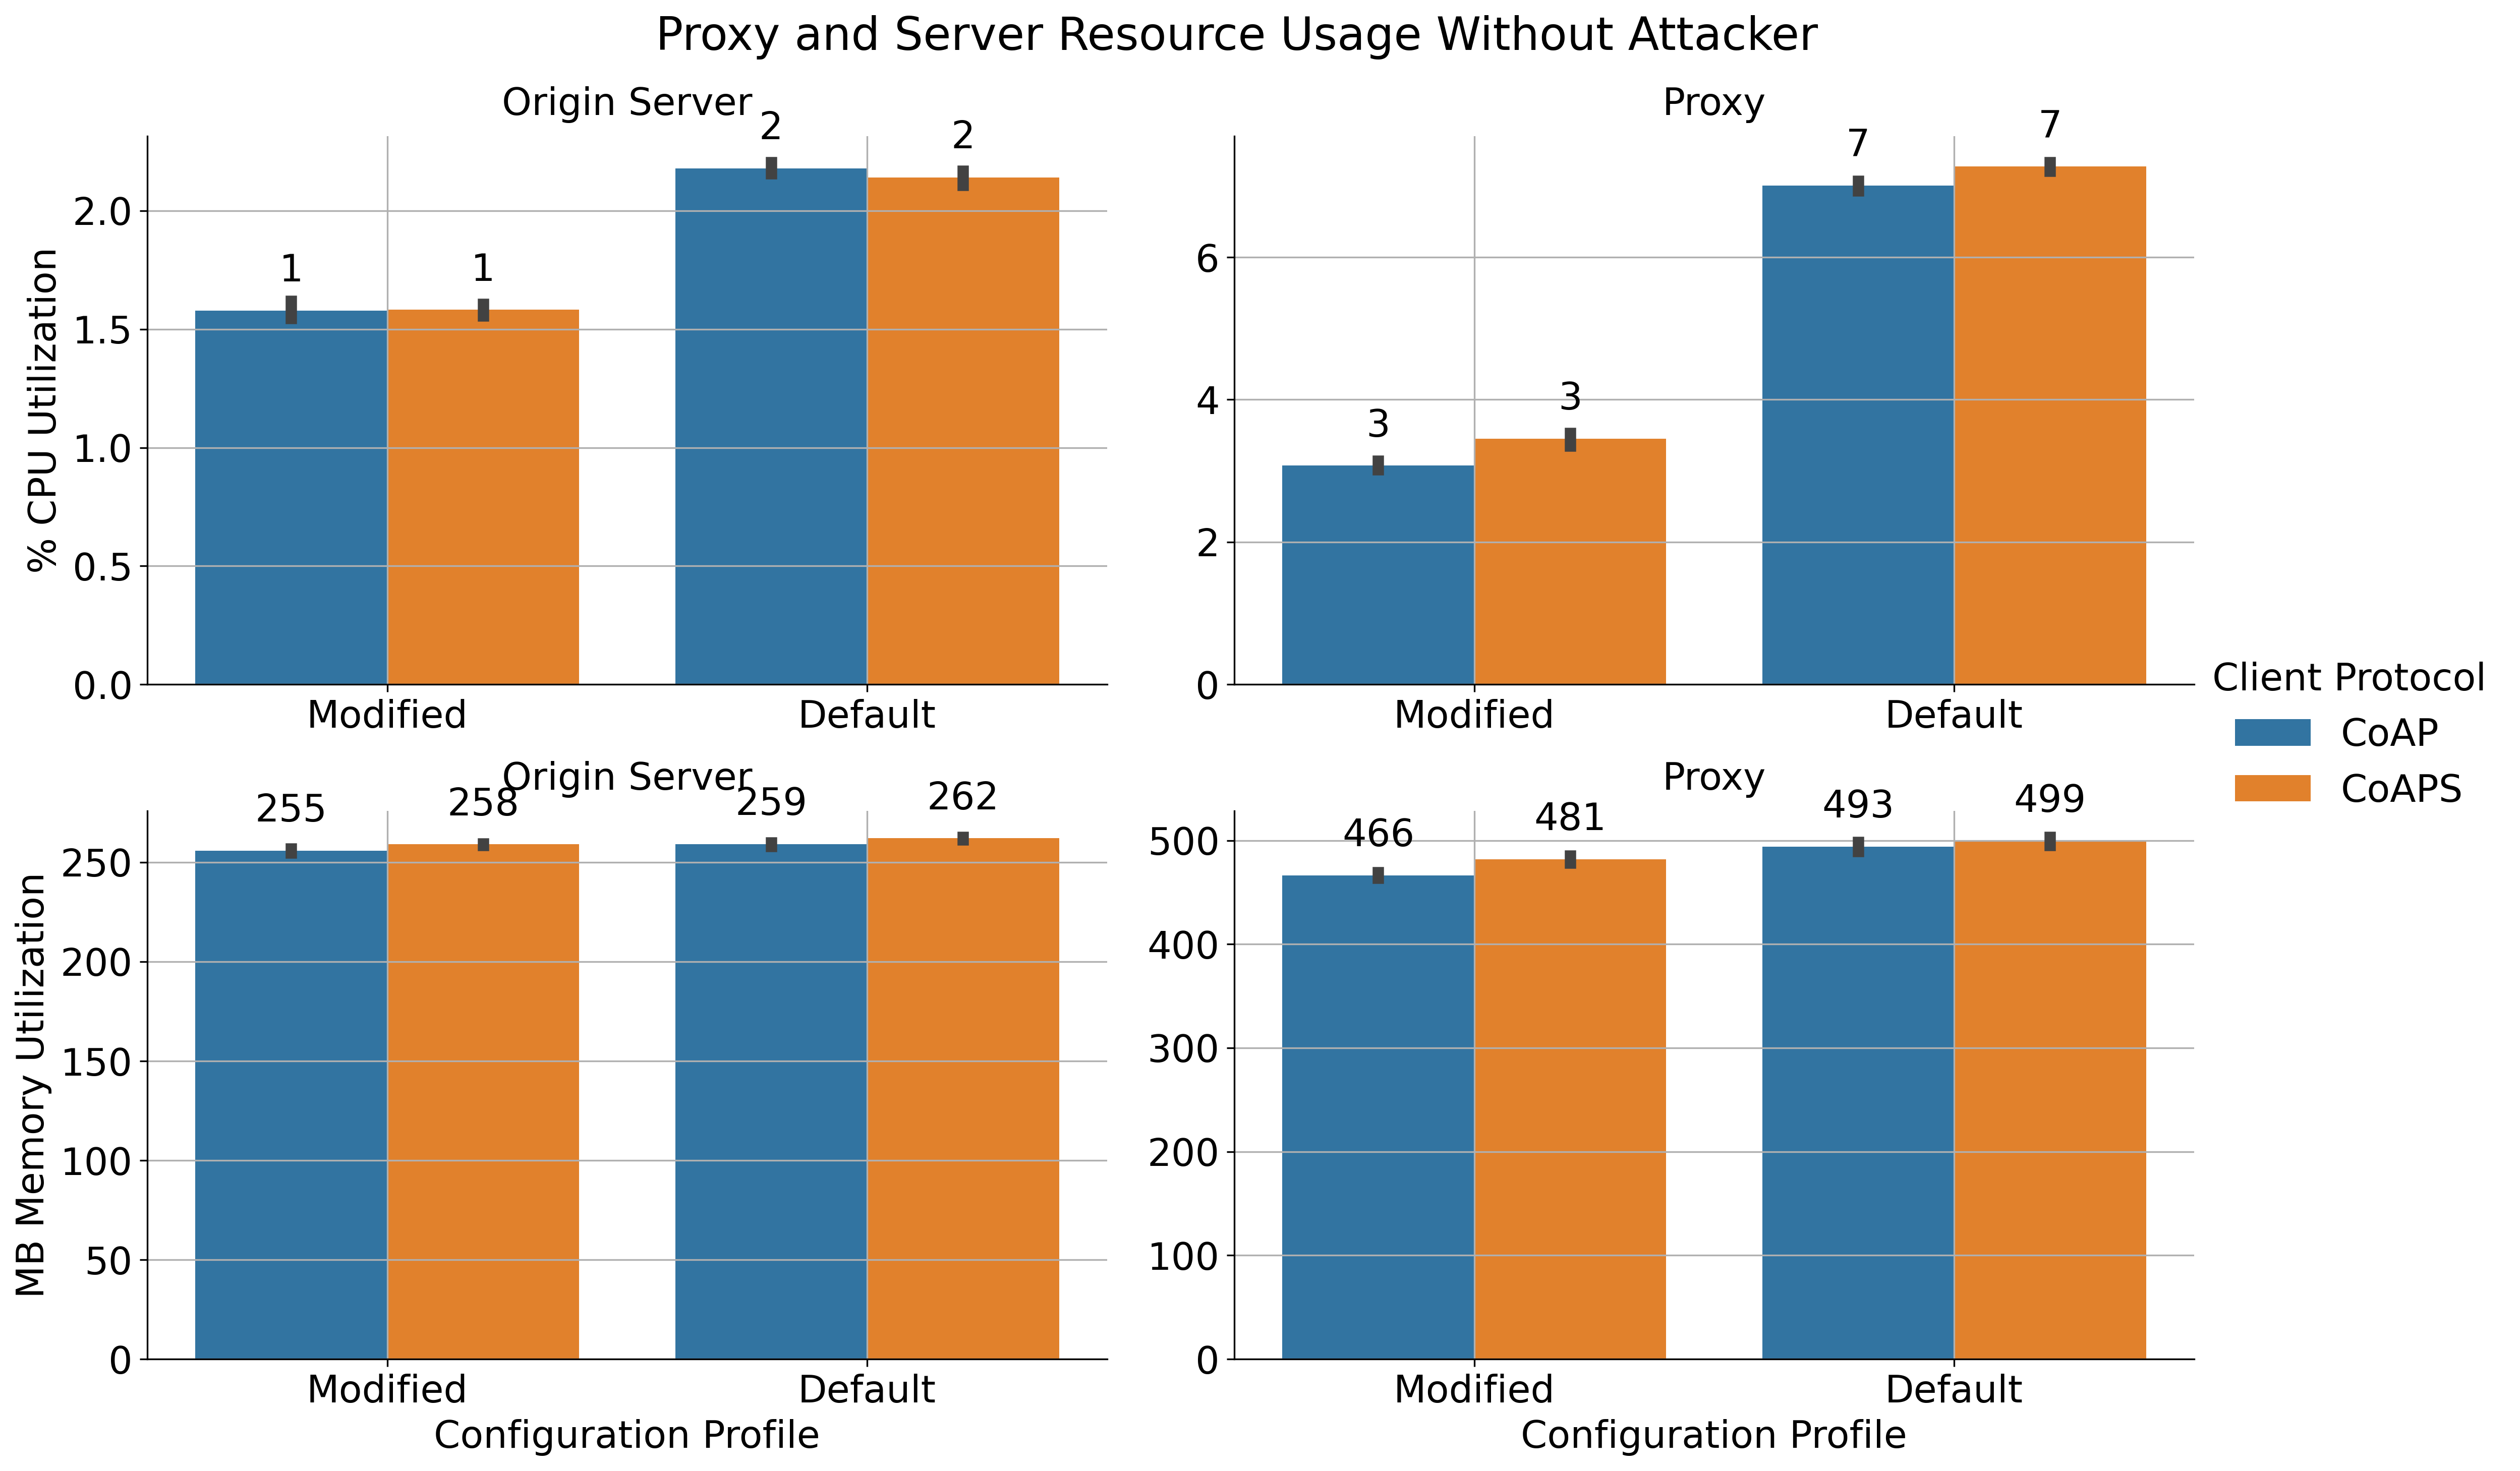

CPU times: user 3.3 s, sys: 274 ms, total: 3.57 s
Wall time: 3.3 s


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,Client Protocol,run_proxy_with_https,Attacker Presence,configuration_profile
80,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,% CPU Utilization,1.538571,0.5,8.2,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAP,True,Without Attacker,Modified
110,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,Origin Server,MB Memory Utilization,259.333884,244.0,261.0,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
103,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,MB Memory Utilization,476.947107,265.0,508.0,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
104,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Origin Server,% CPU Utilization,1.598571,0.4,10.0,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
105,thesis_group_proxy_connection_reuse_8clients_noattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Proxy,% CPU Utilization,3.441429,0.3,27.8,0mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,Without Attacker,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,4,Proxy,MB Memory Utilization,493.816529,243.0,513.0,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
16,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,Origin Server,% CPU Utilization,2.142143,0.5,9.1,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
17,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,Proxy,% CPU Utilization,7.062143,0.5,22.0,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
39,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_dtls_https,5,Proxy,MB Memory Utilization,502.249587,245.0,530.0,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAPS,True,Without Attacker,Default


In [17]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .rename(columns={
    "run_proxy_with_dtls": "Client Protocol",
    "run_attacker": "Attacker Presence",
  })
  .sort_values(by=["configuration_profile"], ascending=False)
)

df = df[df["Attacker Presence"] == "Without Attacker"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="Client Protocol",
  sharey=False,
  sharex=False,
  aspect=1.5,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
  pad=10,
)
g.set_xlabels("Configuration Profile")
g.set_ylabels("Average Metric Value")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

axes = [ g.axes[i, j] for i in range(2) for j in range(2) ]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=10)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Proxy and Server Resource Usage Without Attacker")

plt.show()

df

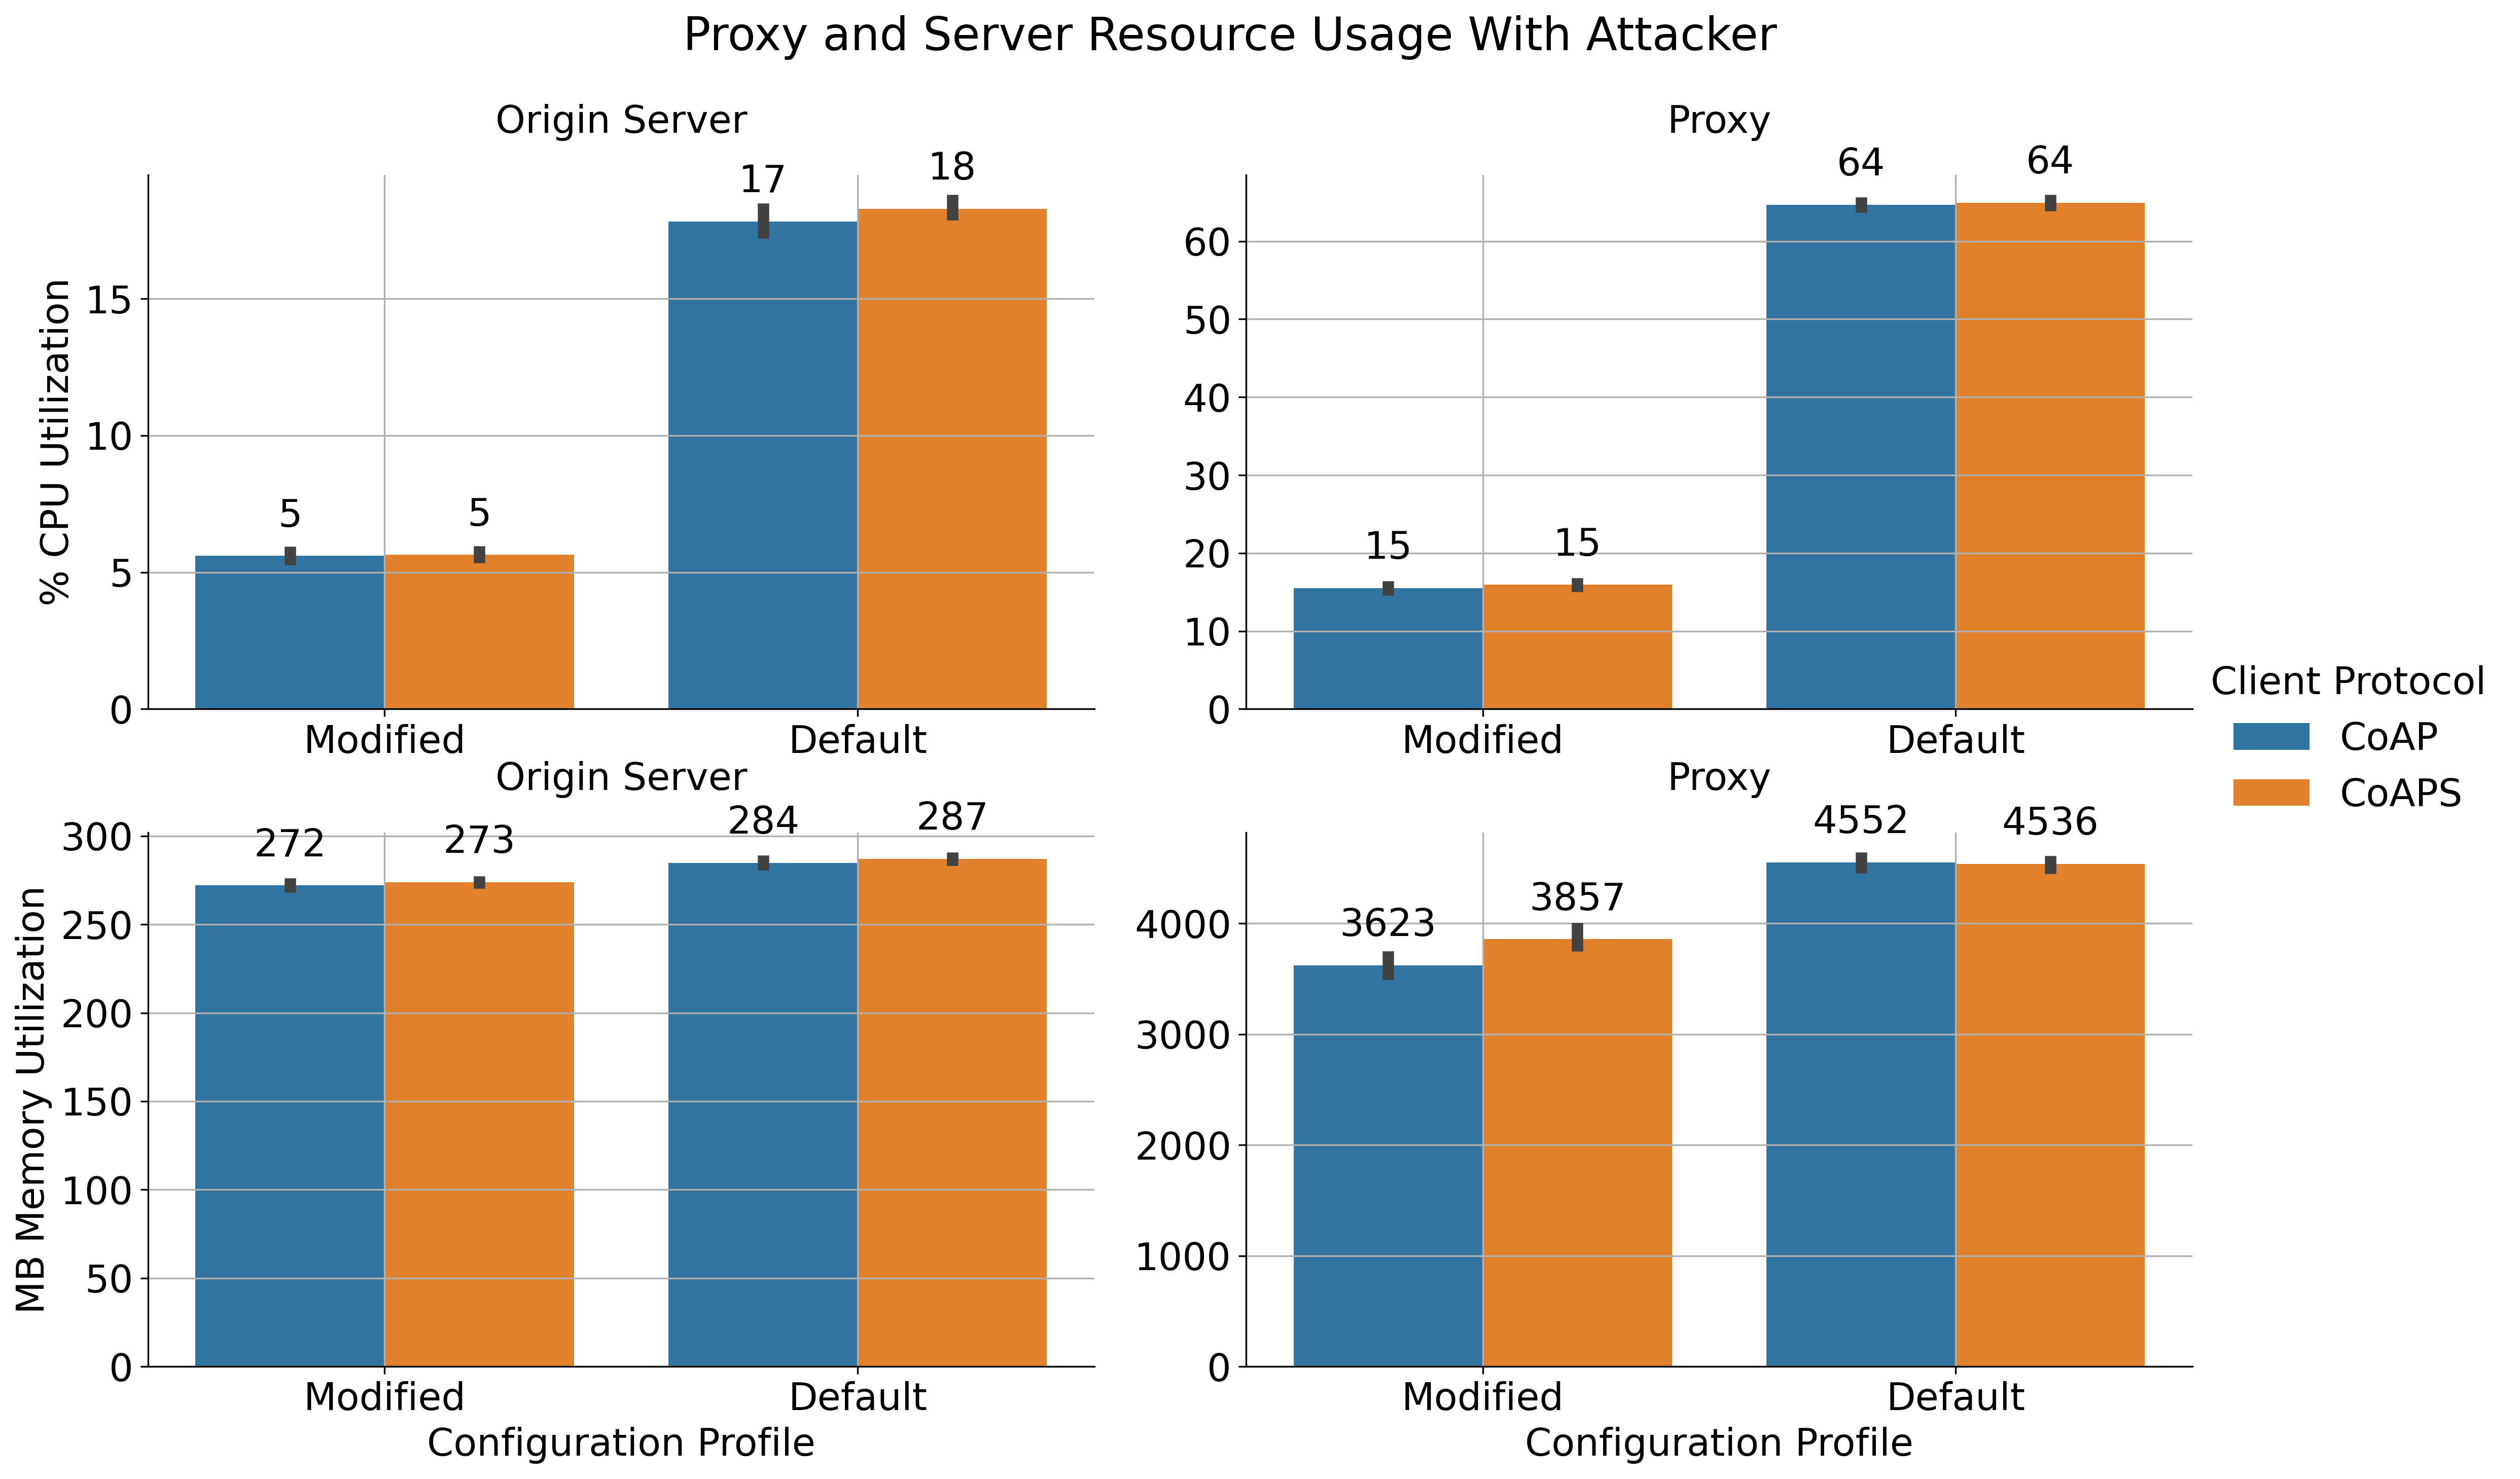

CPU times: user 3.03 s, sys: 472 ms, total: 3.5 s
Wall time: 3.2 s


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,Client Protocol,run_proxy_with_https,Attacker Presence,configuration_profile
120,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,% CPU Utilization,5.495714,0.5,24.8,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAP,True,With Attacker,Modified
121,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,% CPU Utilization,15.705714,0.4,89.8,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAP,True,With Attacker,Modified
150,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,Origin Server,MB Memory Utilization,274.056198,251.0,299.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
143,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,MB Memory Utilization,4038.835000,269.0,6760.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
144,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Origin Server,% CPU Utilization,5.673571,0.5,25.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,4,Origin Server,MB Memory Utilization,286.183028,245.0,340.0,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
55,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,4,Proxy,MB Memory Utilization,4533.022430,248.0,7821.0,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
56,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,Origin Server,% CPU Utilization,17.487143,0.5,38.5,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
57,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,Proxy,% CPU Utilization,65.002857,0.5,99.6,100mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default


In [67]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .rename(columns={
    "run_proxy_with_dtls": "Client Protocol",
    "run_attacker": "Attacker Presence",
  })
  .sort_values(by=["configuration_profile"], ascending=False)
)

df = df[df["Attacker Presence"] == "With Attacker"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="Client Protocol",
  sharey=False,
  sharex=False,
  aspect=1.5,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
  pad=20,
)
g.set_xlabels("Configuration Profile")
g.set_ylabels("Average Metric Value")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

axes = [ g.axes[i, j] for i in range(2) for j in range(2) ]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=10)

g.fig.subplots_adjust(top=0.875)
g.fig.suptitle("Proxy and Server Resource Usage With Attacker")

plt.show()

df

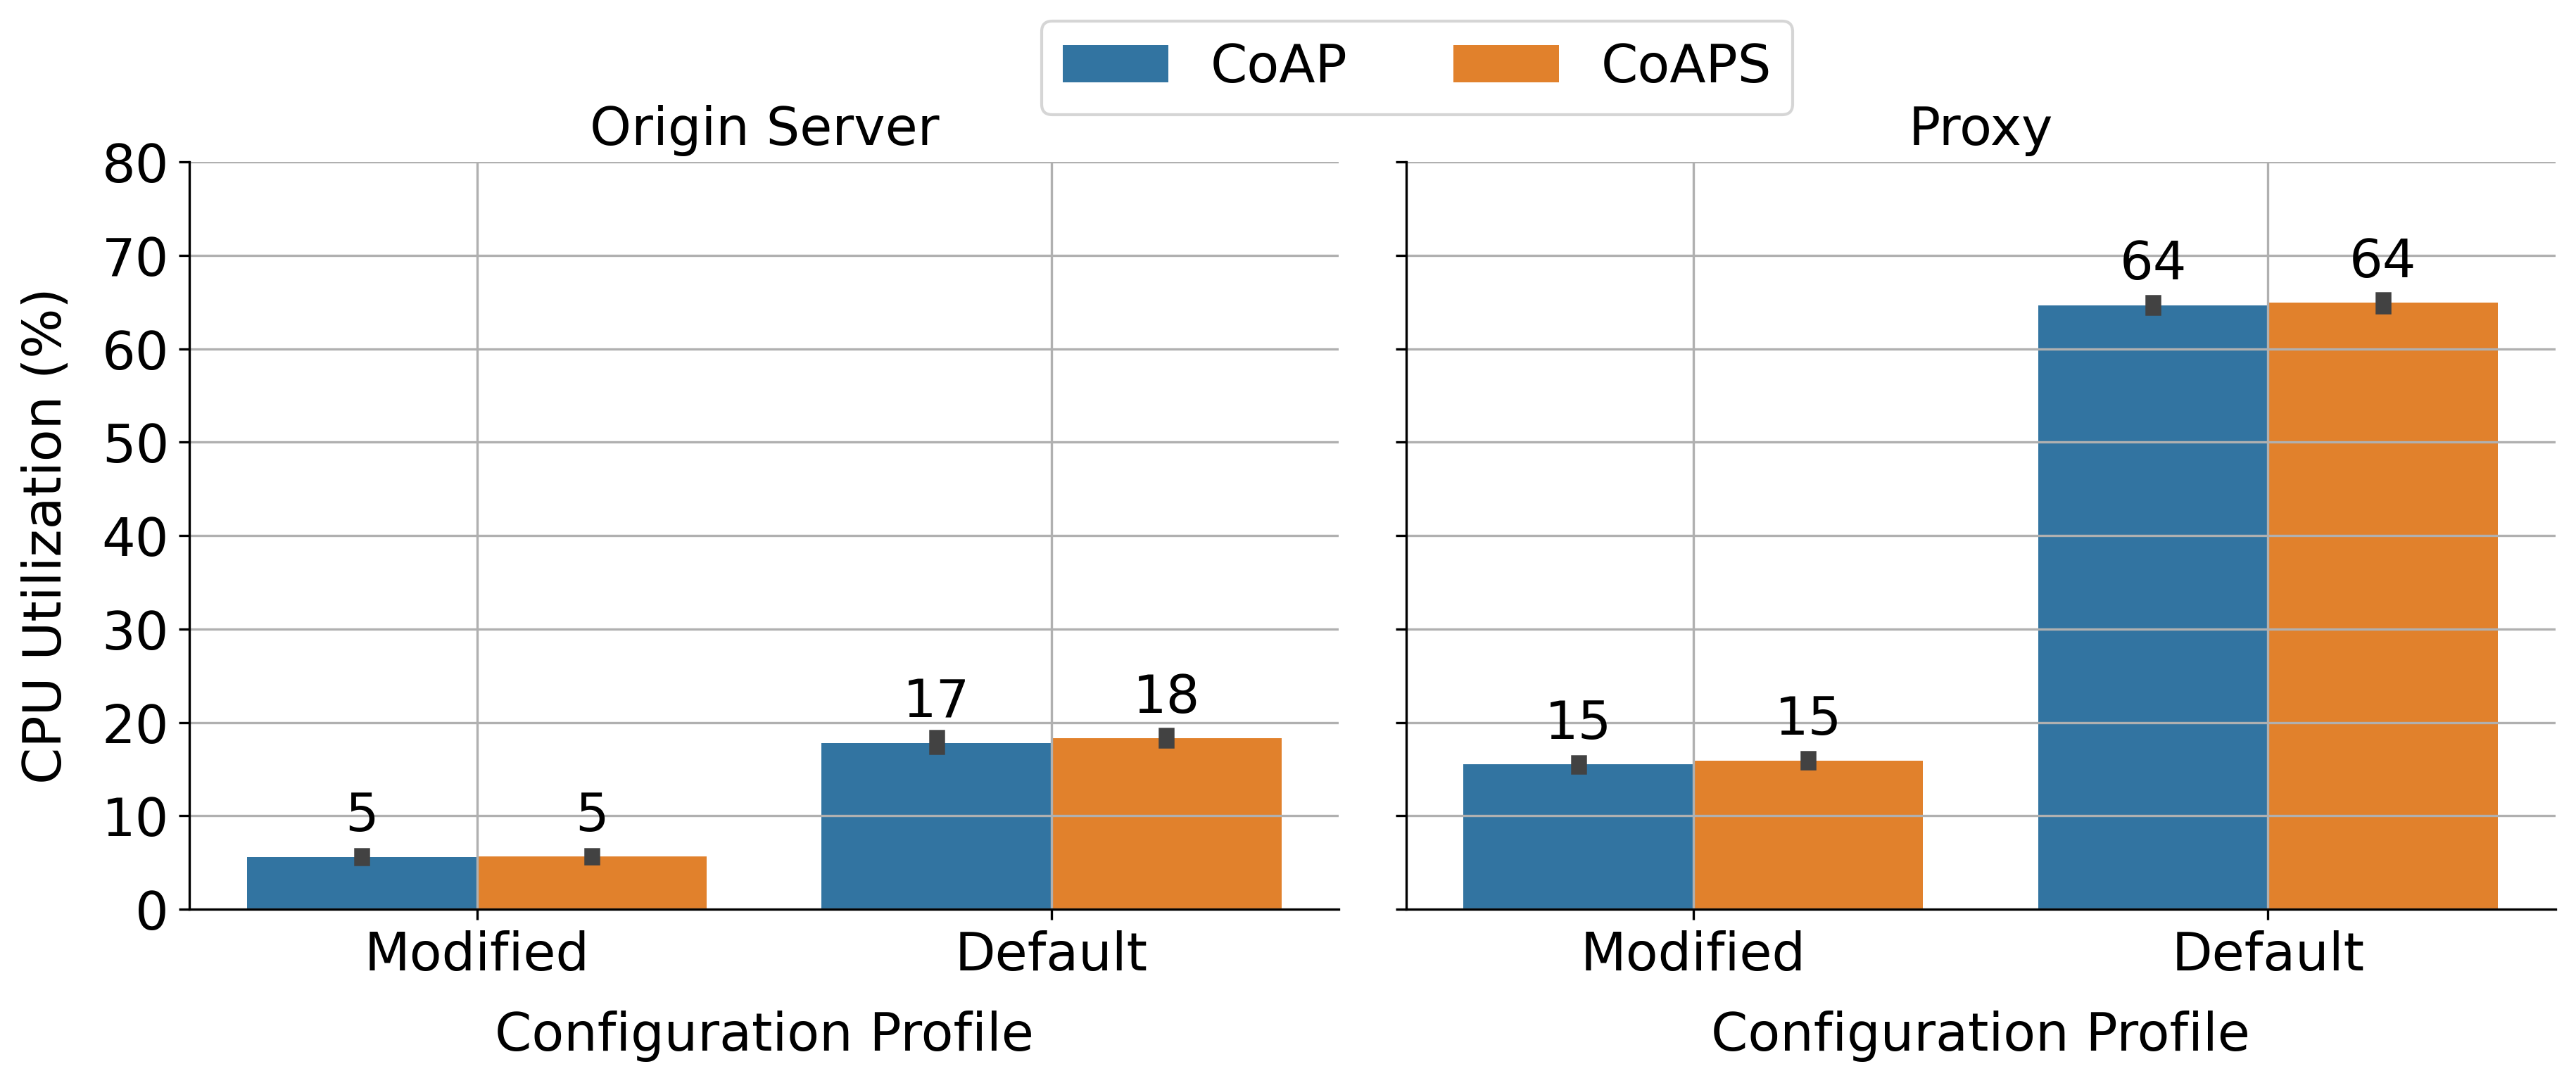

CPU times: user 1.67 s, sys: 124 ms, total: 1.79 s
Wall time: 1.48 s


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,Client Protocol,run_proxy_with_https,Attacker Presence,configuration_profile
120,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,% CPU Utilization,5.495714,0.5,24.8,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAP,True,With Attacker,Modified
121,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,% CPU Utilization,15.705714,0.4,89.8,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAP,True,With Attacker,Modified
144,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Origin Server,% CPU Utilization,5.673571,0.5,25.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
145,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Proxy,% CPU Utilization,16.042143,0.4,88.1,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
148,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,Origin Server,% CPU Utilization,5.594286,0.4,23.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
149,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,Proxy,% CPU Utilization,15.795000,0.4,86.9,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
141,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,% CPU Utilization,15.629286,0.4,84.9,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
152,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,Origin Server,% CPU Utilization,5.493571,0.5,24.8,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
153,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,Proxy,% CPU Utilization,16.150714,0.5,86.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
156,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,Origin Server,% CPU Utilization,5.586429,0.4,23.4,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified


In [75]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .rename(columns={
    "run_proxy_with_dtls": "Client Protocol",
    "run_attacker": "Attacker Presence",
  })
  .sort_values(by=["configuration_profile"], ascending=False)
)

df = df[df["Attacker Presence"] == "With Attacker"]
df = df[df["metric_type"] == "% CPU Utilization"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="Client Protocol",
  sharey=True,
  sharex=False,
  aspect=1.25,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Configuration Profile", labelpad=10)

g.set(
  yticks=np.arange(0,81, 10),
)

g.axes[0,0].set_ylabel("CPU Utilization (%)", labelpad=10)
g.axes[0,1].set_ylabel("")

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")

axes = [ g.axes[0, i] for i in range(2) ]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.48, 1.05),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

df

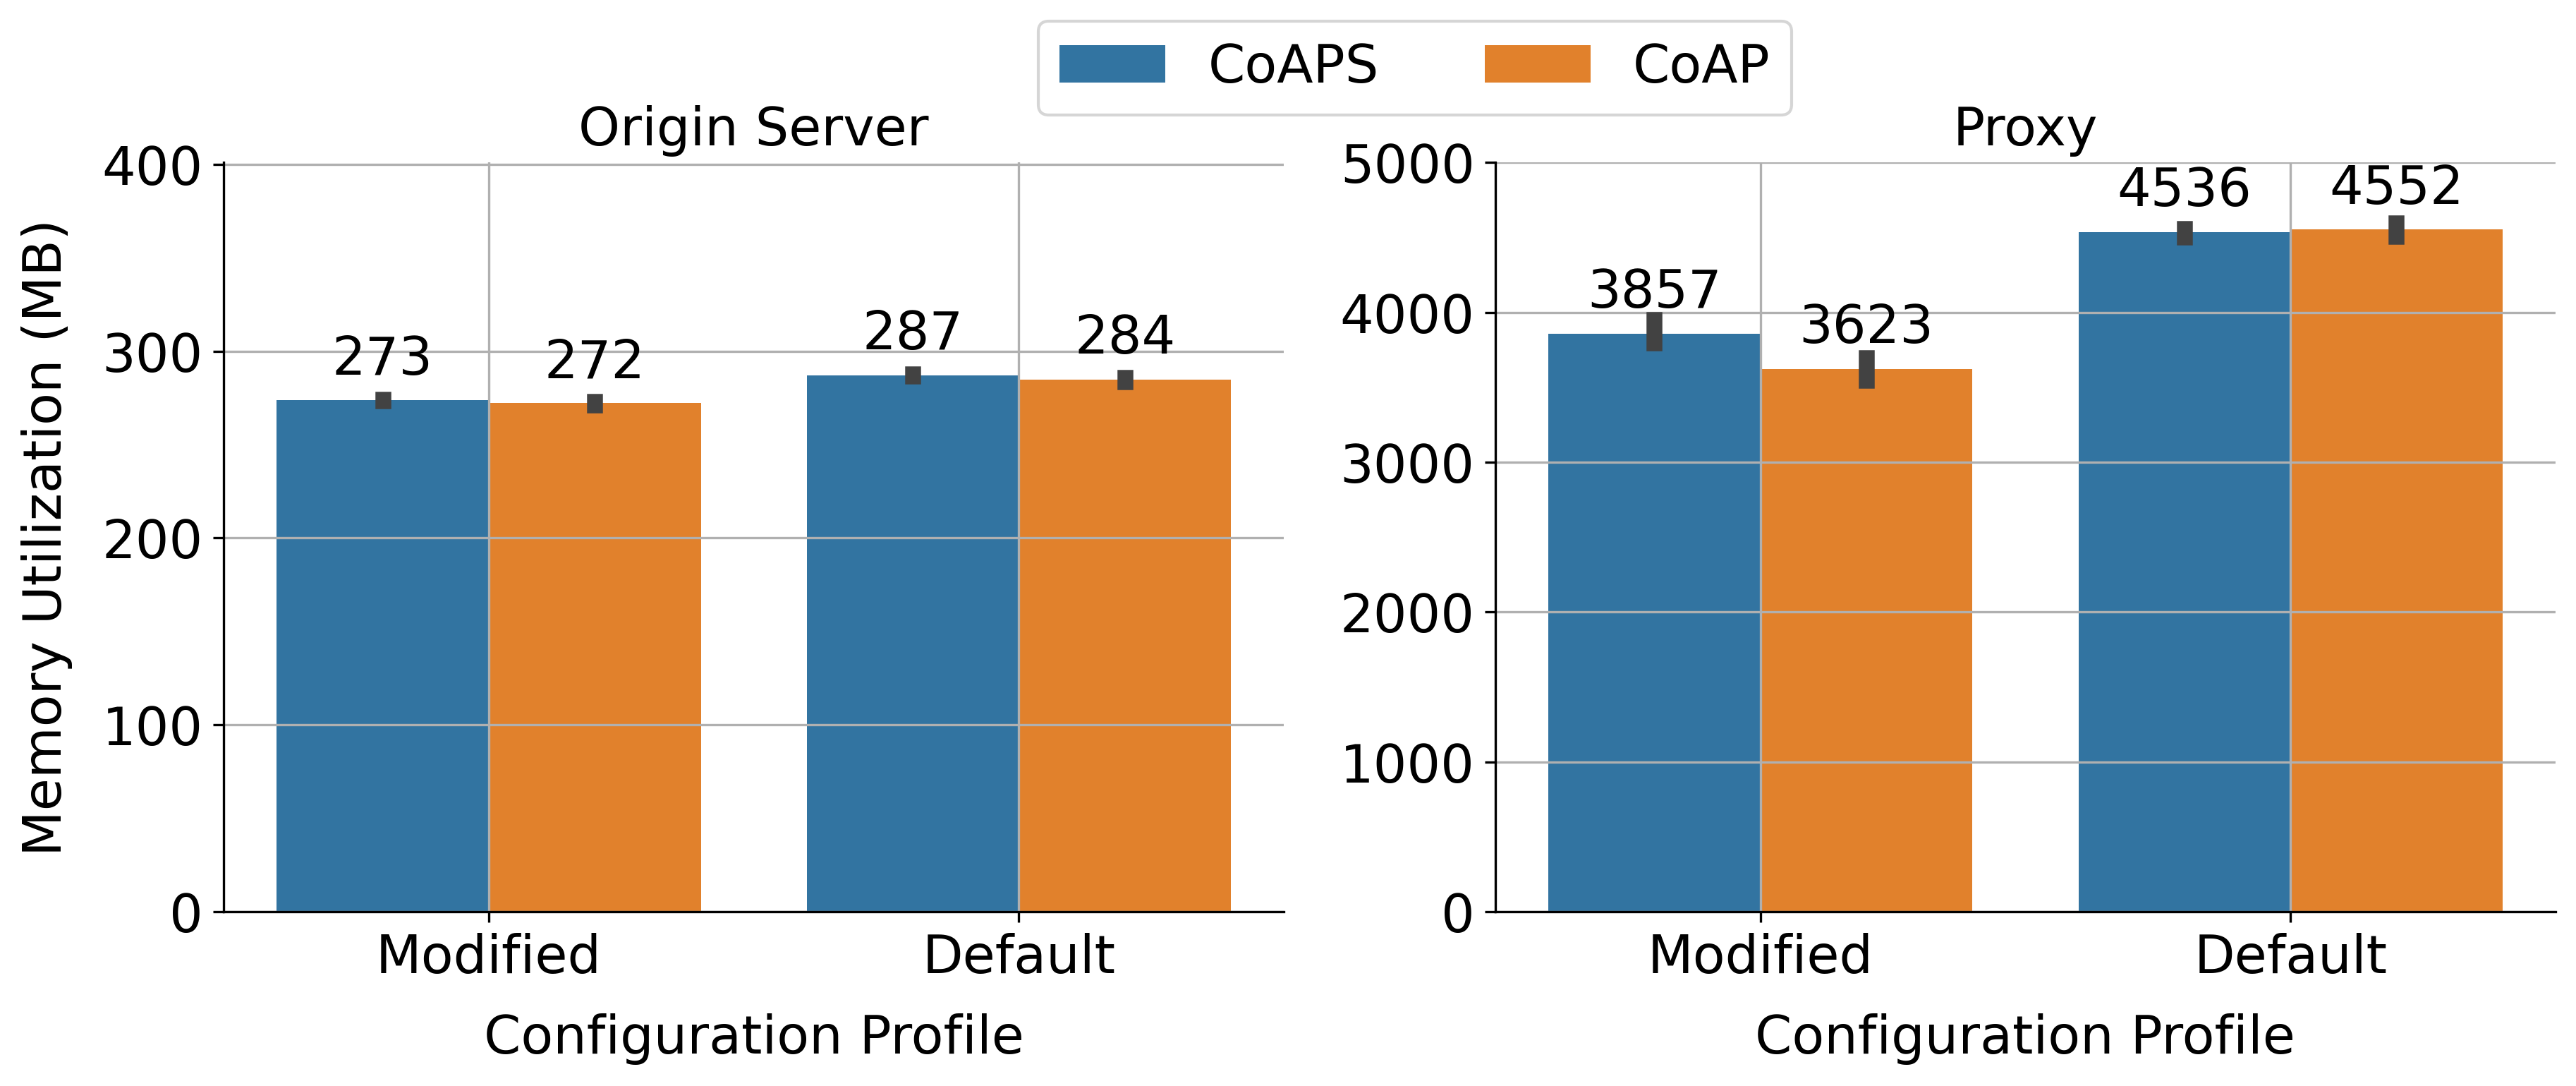

CPU times: user 1.52 s, sys: 157 ms, total: 1.67 s
Wall time: 1.36 s


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,Client Protocol,run_proxy_with_https,Attacker Presence,configuration_profile
150,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,Origin Server,MB Memory Utilization,274.056198,251.0,299.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
143,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,MB Memory Utilization,4038.835000,269.0,6760.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
146,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Origin Server,MB Memory Utilization,273.327273,252.0,301.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
147,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,2,Proxy,MB Memory Utilization,3782.860000,268.0,6249.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
151,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,Proxy,MB Memory Utilization,3814.594324,268.0,6296.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
154,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,Origin Server,MB Memory Utilization,273.776490,252.0,297.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
155,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,Proxy,MB Memory Utilization,3856.508333,268.0,6450.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
158,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,Origin Server,MB Memory Utilization,274.095868,251.0,301.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
142,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,MB Memory Utilization,273.821488,251.0,301.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
122,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,MB Memory Utilization,270.585124,248.0,294.0,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAP,True,With Attacker,Modified


In [79]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
  .rename(columns={
    "run_proxy_with_dtls": "Client Protocol",
    "run_attacker": "Attacker Presence",
  })
  .sort_values(by=["configuration_profile"], ascending=False)
)

df = df[df["Attacker Presence"] == "With Attacker"]
df = df[df["metric_type"] == "MB Memory Utilization"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="Client Protocol",
  sharey=False,
  sharex=False,
  aspect=1.25,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Configuration Profile", labelpad=10)

# g.set(
#   yticks=np.arange(0,81, 10),
# )

g.axes[0,0].set_ylabel("Memory Utilization (MB)", labelpad=10)
g.axes[0,1].set_ylabel("")

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")

g.axes[0,0].set_ylim(0, 401)
g.axes[0,1].set_ylim(0, 5001)

axes = [ g.axes[0, i] for i in range(2) ]
for ax in axes:
  ax.grid(True, axis="y")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.48, 1.05),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

df

In [19]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  df = (
    pl
    .scan_parquet(
      f"{experiment_dir}/*/{exp_id}.connections.parquet"
    )
  )
  lazy_dfs.append(df)

lazy_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)

connections_df = (
  pl
  .concat(lazy_dfs)

  # Filter for proxy's view of syn-acks or fin-acks coming from server
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])

  # And finally convert to pandas for plotting.
  .collect()
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

# This method also does not include a connection count at the last time
# the proxy is meant to be active -- so we fill that value in based on the
# last value.
last_connection_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"], sort=True)
  .agg(
    max_timestamp=("timestamp", "max"),
    last_timestamp=("timestamp", "last"),
    max_open_connections=("open_connections", "max"),
    last_open_connections=("open_connections", "last"),
    last_cum_syn=("cum_syn", "last"),
    last_cum_fin=("cum_fin", "last"),
  )
  .reset_index()
)
# assert last_connection_df["max_timestamp"].equals(last_connection_df["last_timestamp"])
# assert last_connection_df["max_open_connections"].equals(last_connection_df["last_open_connections"])
records = list()
for r in last_connection_df.to_dict(orient="records"):
  records.append({
    "exp_id"          : r["exp_id"],
    "trial"           : r["trial"],
    "observer_id"     : r["observer_id"],
    "timestamp"       : 140,
    "cum_syn"         : r["last_cum_syn"],
    "cum_fin"         : r["last_cum_fin"],
    "open_connections": r["last_open_connections"],
  })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

connections_df

CPU times: user 2min 11s, sys: 5min 21s, total: 7min 33s
Wall time: 1min 30s


,exp_id,trial,observer_id,timestamp,cum_syn,cum_fin,open_connections,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,0.000000,0,0,0,0mbps,256,0,...,250,60,4,150,1,True,CoAP,True,False,Default
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,0.061390,1,0,1,0mbps,256,0,...,250,60,4,150,1,True,CoAP,True,False,Default
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,0.403046,2,0,2,0mbps,256,0,...,250,60,4,150,1,True,CoAP,True,False,Default
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,0.498277,3,0,3,0mbps,256,0,...,250,60,4,150,1,True,CoAP,True,False,Default
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,0.596194,4,0,4,0mbps,256,0,...,250,60,4,150,1,True,CoAP,True,False,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778959,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,128.289726,52,49,3,100mbps,256,0,...,50,5,2,5,1,True,CoAPS,True,True,Modified
1778960,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,128.719208,52,50,2,100mbps,256,0,...,50,5,2,5,1,True,CoAPS,True,True,Modified
1778961,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,130.221829,52,51,1,100mbps,256,0,...,50,5,2,5,1,True,CoAPS,True,True,Modified
1778962,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,131.295056,52,52,0,100mbps,256,0,...,50,5,2,5,1,True,CoAPS,True,True,Modified


In [51]:
%%time 

client_journey_sql = f"""
WITH client_sends AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
),

proxy_events AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, proxy_dnids))})   -- proxy dnids
),

client_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.observer_id AS observer_id,
  client_sends.trial AS trial,
  client_sends.message_marker AS message_marker,
  (groupArray(client_recvs.coap_code))[1] AS coap_code,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS client_to_self_rtt_ms,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec
FROM
  client_sends
  JOIN client_recvs
    ON client_recvs.exp_id = client_sends.exp_id
    AND client_recvs.trial = client_sends.trial
    AND client_recvs.message_marker = client_sends.message_marker
    AND client_recvs.observer_id = client_sends.observer_id
GROUP BY
  client_sends.exp_id, client_sends.observer_id, client_sends.trial, client_sends.message_marker
ORDER BY
  exp_id, trial, message_marker, first_send_time_sec
"""

client_journey_df = client.query_dataframe(client_journey_sql)

client_journey_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_journey_df

CPU times: user 1.33 s, sys: 620 ms, total: 1.95 s
Wall time: 3.79 s


,exp_id,observer_id,trial,message_marker,coap_code,first_send_time_sec,client_to_self_rtt_ms,first_recv_time_sec
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,1,content,0.000000,374.155045,0.374155
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,2,content,0.389228,93.606949,0.482835
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,3,content,0.484991,96.386909,0.581378
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,4,content,0.583750,92.355013,0.676105
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,5,content,0.678485,86.613178,0.765098
...,...,...,...,...,...,...,...,...
460316,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,711950,content,125.419955,52.803040,125.472758
460317,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,711951,content,125.473589,52.819014,125.526408
460318,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,711952,content,125.527217,52.809000,125.580026
460319,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,711953,content,125.580866,52.830935,125.633697


In [52]:
%%time

# `client_journey_df` is far too detailed for plotting, but
# is useful for non-plotting use-cases so we keep it around.
# But for plotting, we summarize RTTs in discrete intervals
# of time instead, thus reducing the amount of data.

reduced_client_journey_df = (
  client_journey_df
  .groupby(by=[
    "exp_id", "observer_id", "trial",
    pd.cut(client_journey_df["first_send_time_sec"], np.arange(0,121,5))
  ])
  .agg(
    client_to_self_rtt_ms=("client_to_self_rtt_ms", "mean"),
  )
  .reset_index()
  .melt(
    id_vars=["exp_id", "observer_id", "trial", "first_send_time_sec"],
    value_vars=["client_to_self_rtt_ms"],
    var_name="sub_journey_name",
    value_name="sub_journey_time_ms",
  )
)

reduced_client_journey_df["first_send_time_sec"] = reduced_client_journey_df["first_send_time_sec"].map(operator.attrgetter("right"))
reduced_client_journey_df = reduced_client_journey_df.merge(exp_df, on="exp_id", how="left")

reduced_client_journey_df

CPU times: user 311 ms, sys: 1.12 ms, total: 312 ms
Wall time: 310 ms


,exp_id,observer_id,trial,first_send_time_sec,sub_journey_name,sub_journey_time_ms,attacker_rate,server_connections,max_keep_alive_requests,num_clients,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,5,client_to_self_rtt_ms,82.533745,0mbps,256,0,8,...,250,60,4,150,1,True,False,True,False,Default
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,10,client_to_self_rtt_ms,78.311682,0mbps,256,0,8,...,250,60,4,150,1,True,False,True,False,Default
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,15,client_to_self_rtt_ms,77.808463,0mbps,256,0,8,...,250,60,4,150,1,True,False,True,False,Default
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,20,client_to_self_rtt_ms,77.238973,0mbps,256,0,8,...,250,60,4,150,1,True,False,True,False,Default
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,client1,1,25,client_to_self_rtt_ms,77.375188,0mbps,256,0,8,...,250,60,4,150,1,True,False,True,False,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,100,client_to_self_rtt_ms,52.203244,100mbps,256,0,8,...,50,5,2,5,1,True,True,True,True,Modified
7676,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,105,client_to_self_rtt_ms,52.246469,100mbps,256,0,8,...,50,5,2,5,1,True,True,True,True,Modified
7677,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,110,client_to_self_rtt_ms,52.147271,100mbps,256,0,8,...,50,5,2,5,1,True,True,True,True,Modified
7678,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,client8,5,115,client_to_self_rtt_ms,52.148192,100mbps,256,0,8,...,50,5,2,5,1,True,True,True,True,Modified


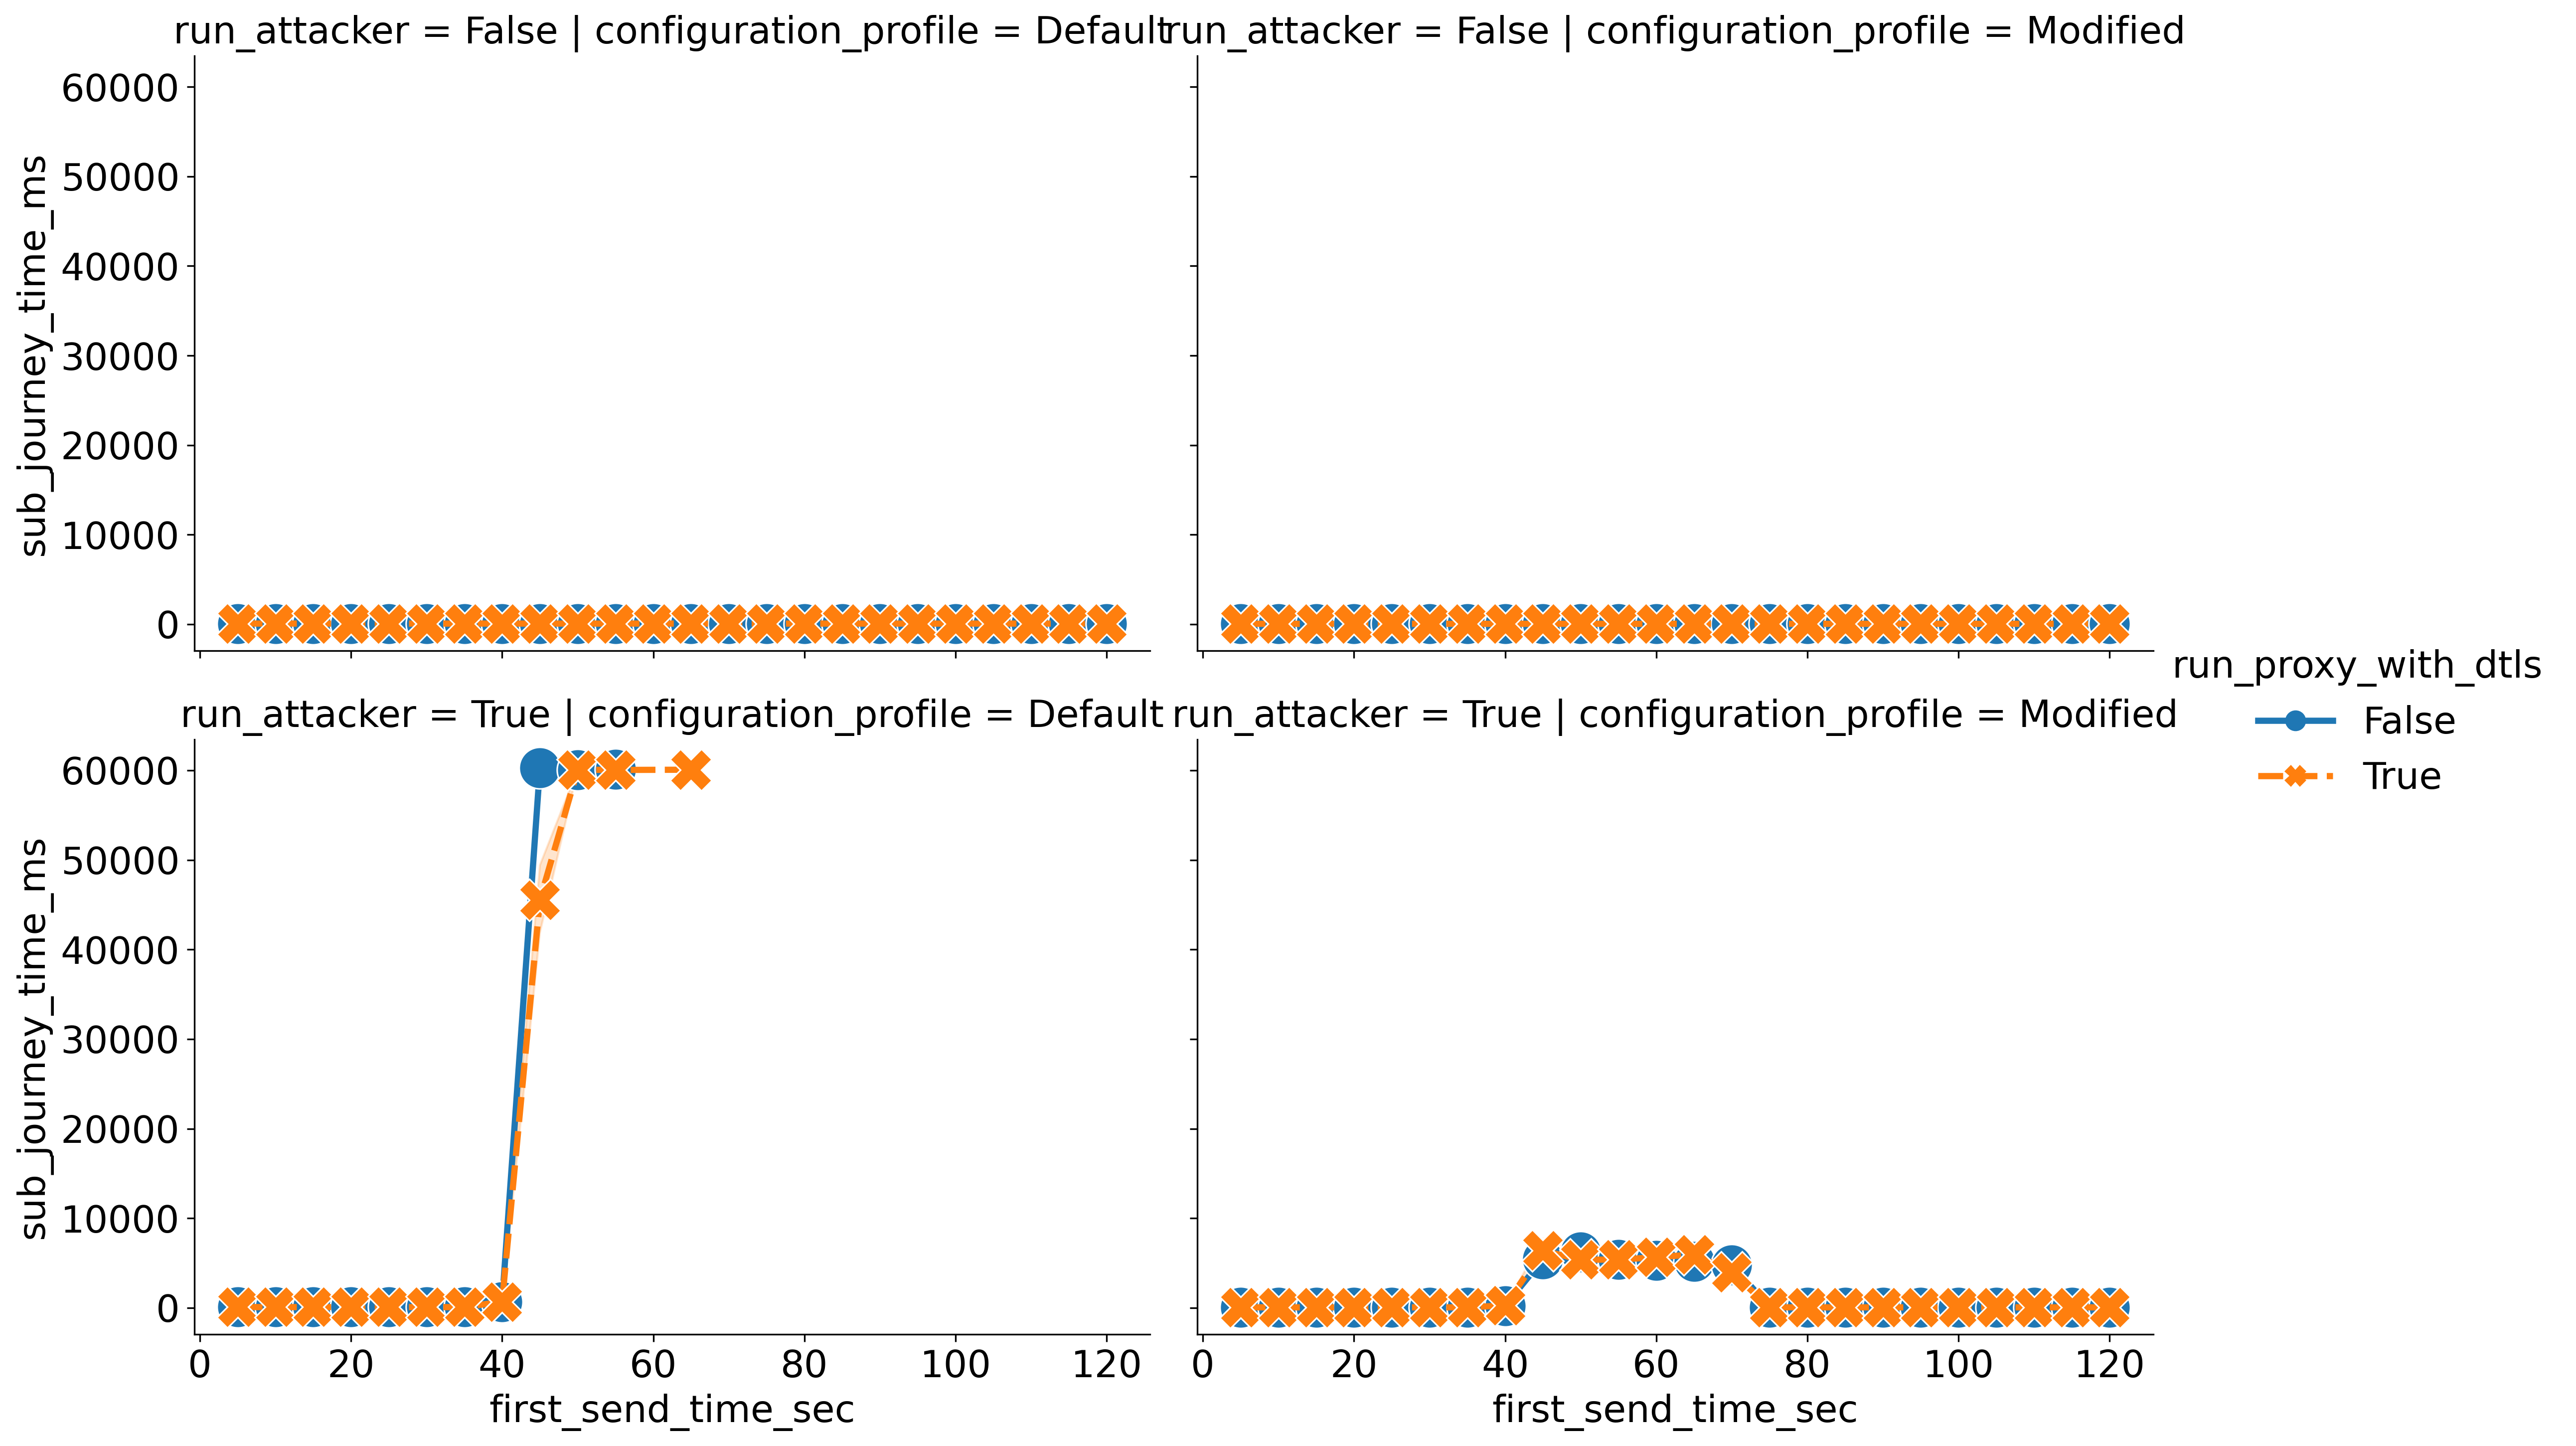

CPU times: user 7.83 s, sys: 157 ms, total: 7.99 s
Wall time: 7.7 s


In [ ]:
%%time

df = reduced_client_journey_df

g = sns.relplot(
  data=df,
  kind="line",
  x="first_send_time_sec",
  y="sub_journey_time_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  row="run_attacker",
  col="configuration_profile",
  markers=True,
  markersize=20,
  aspect=1.5,
)

plt.show()

In [53]:
%%time

originserver_message_sql = f"""
WITH originserver_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observer_id AS observer_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.message_marker AS message_marker,
    hm.http_response_code AS http_response_code,
    m.src_id AS src_id,
    m.dst_id AS dst_id
  FROM
    event e
  JOIN
    message m ON m.message_id = e.message_id
  JOIN
    http_message hm ON hm.hmci = m.http_message
  JOIN
    deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, proxy_dnids))})   -- proxy dnids
    AND (
      m.src_id IN ({','.join(map(str, originserver_node_ids))}) -- originservers are senders (node ID)
      OR m.dst_id IN ({','.join(map(str, originserver_node_ids))}) -- originservers are receivers (node ID)
    )
),

originserver_response_breakdown AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    src_id,
    dst_id,
    http_response_code AS response_code,
    COUNT(http_response_code) AS response_code_count
  FROM
    originserver_recvs
  GROUP BY
    exp_id, trial, observer_id, src_id, dst_id, response_code
  ORDER BY
    exp_id, trial, observer_id, src_id, dst_id, response_code
)

SELECT * FROM originserver_response_breakdown
"""

originserver_message_df = client.query_dataframe(originserver_message_sql)

originserver_message_df.replace({
  "observer_id": dnid_map_node_name,
  "src_id": node_id_map_node_name,
  "dst_id": node_id_map_node_name,
}, inplace=True)

originserver_message_df = originserver_message_df.merge(exp_df, on="exp_id", how="left")
originserver_message_df.replace(value_map_replacement, inplace=True)

originserver_message_df

CPU times: user 62.7 ms, sys: 3.01 ms, total: 65.7 ms
Wall time: 8.67 s


,exp_id,trial,observer_id,src_id,dst_id,response_code,response_code_count,attacker_rate,server_connections,max_keep_alive_requests,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,originserver,proxy,200,12274,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
1,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,proxy,proxy,originserver,-1,12274,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
2,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,2,proxy,originserver,proxy,200,12277,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
3,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,2,proxy,proxy,originserver,-1,12277,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
4,thesis_group_combined_8clients_noattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,3,proxy,originserver,proxy,200,12285,0mbps,256,0,...,250,60,4,150,1,Reuse Connections,CoAP,True,Without Attacker,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,3,proxy,proxy,originserver,-1,29192,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
76,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,proxy,originserver,proxy,200,126963,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
77,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,proxy,proxy,originserver,-1,126963,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified
78,thesis_group_proxy_connection_reuse_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_reuseconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,originserver,proxy,200,28449,100mbps,256,0,...,50,5,2,5,1,Reuse Connections,CoAPS,True,With Attacker,Modified


In [54]:
%%time

attacker_message_sql = f"""
WITH attacker_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, attacker_dnids))})   -- attacker dnids
  AND m.dst_id IN ({','.join(map(str, attacker_node_ids))}) -- attackers are receivers (node ID)
),

attacker_response_breakdown AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    coap_code AS response_code,
    COUNT(coap_code) AS response_code_count
  FROM
    attacker_recvs
  GROUP BY
    exp_id, trial, observer_id, response_code
  ORDER BY
    exp_id, trial, observer_id, response_code
),

attacker_response_count AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    SUM(response_code_count) AS response_count
  FROM
    attacker_response_breakdown
  GROUP BY
    exp_id, trial, observer_id
  ORDER BY
    exp_id, trial, observer_id
)

SELECT * FROM attacker_response_breakdown
"""

attacker_message_df = client.query_dataframe(attacker_message_sql)

attacker_message_df.observer_id.replace(dnid_map_node_name, inplace=True)
attacker_message_df = attacker_message_df.merge(exp_df, on="exp_id", how="left")
attacker_message_df.replace(value_map_replacement, inplace=True)

attacker_message_df

CPU times: user 32.8 ms, sys: 4.6 ms, total: 37.4 ms
Wall time: 5.07 s


,exp_id,trial,observer_id,response_code,response_code_count,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,...,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,configuration_profile
0,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,attacker,Bad Gateway,470974,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
1,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,1,attacker,Content,158639,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
2,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,2,attacker,Bad Gateway,477110,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
3,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,2,attacker,Content,158729,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
4,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,3,attacker,Bad Gateway,435637,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
5,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,3,attacker,Content,171888,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
6,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,4,attacker,Bad Gateway,481698,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
7,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,4,attacker,Content,155632,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
8,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,attacker,Bad Gateway,485620,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default
9,thesis_group_combined_8clients_withattacker_8000MBheap_250proxyconns_60sec_pxyto_noconnreuse_coap_https,5,attacker,Content,156818,100mbps,256,0,8,5,...,250,60,4,150,1,Reuse Connections,CoAP,True,With Attacker,Default


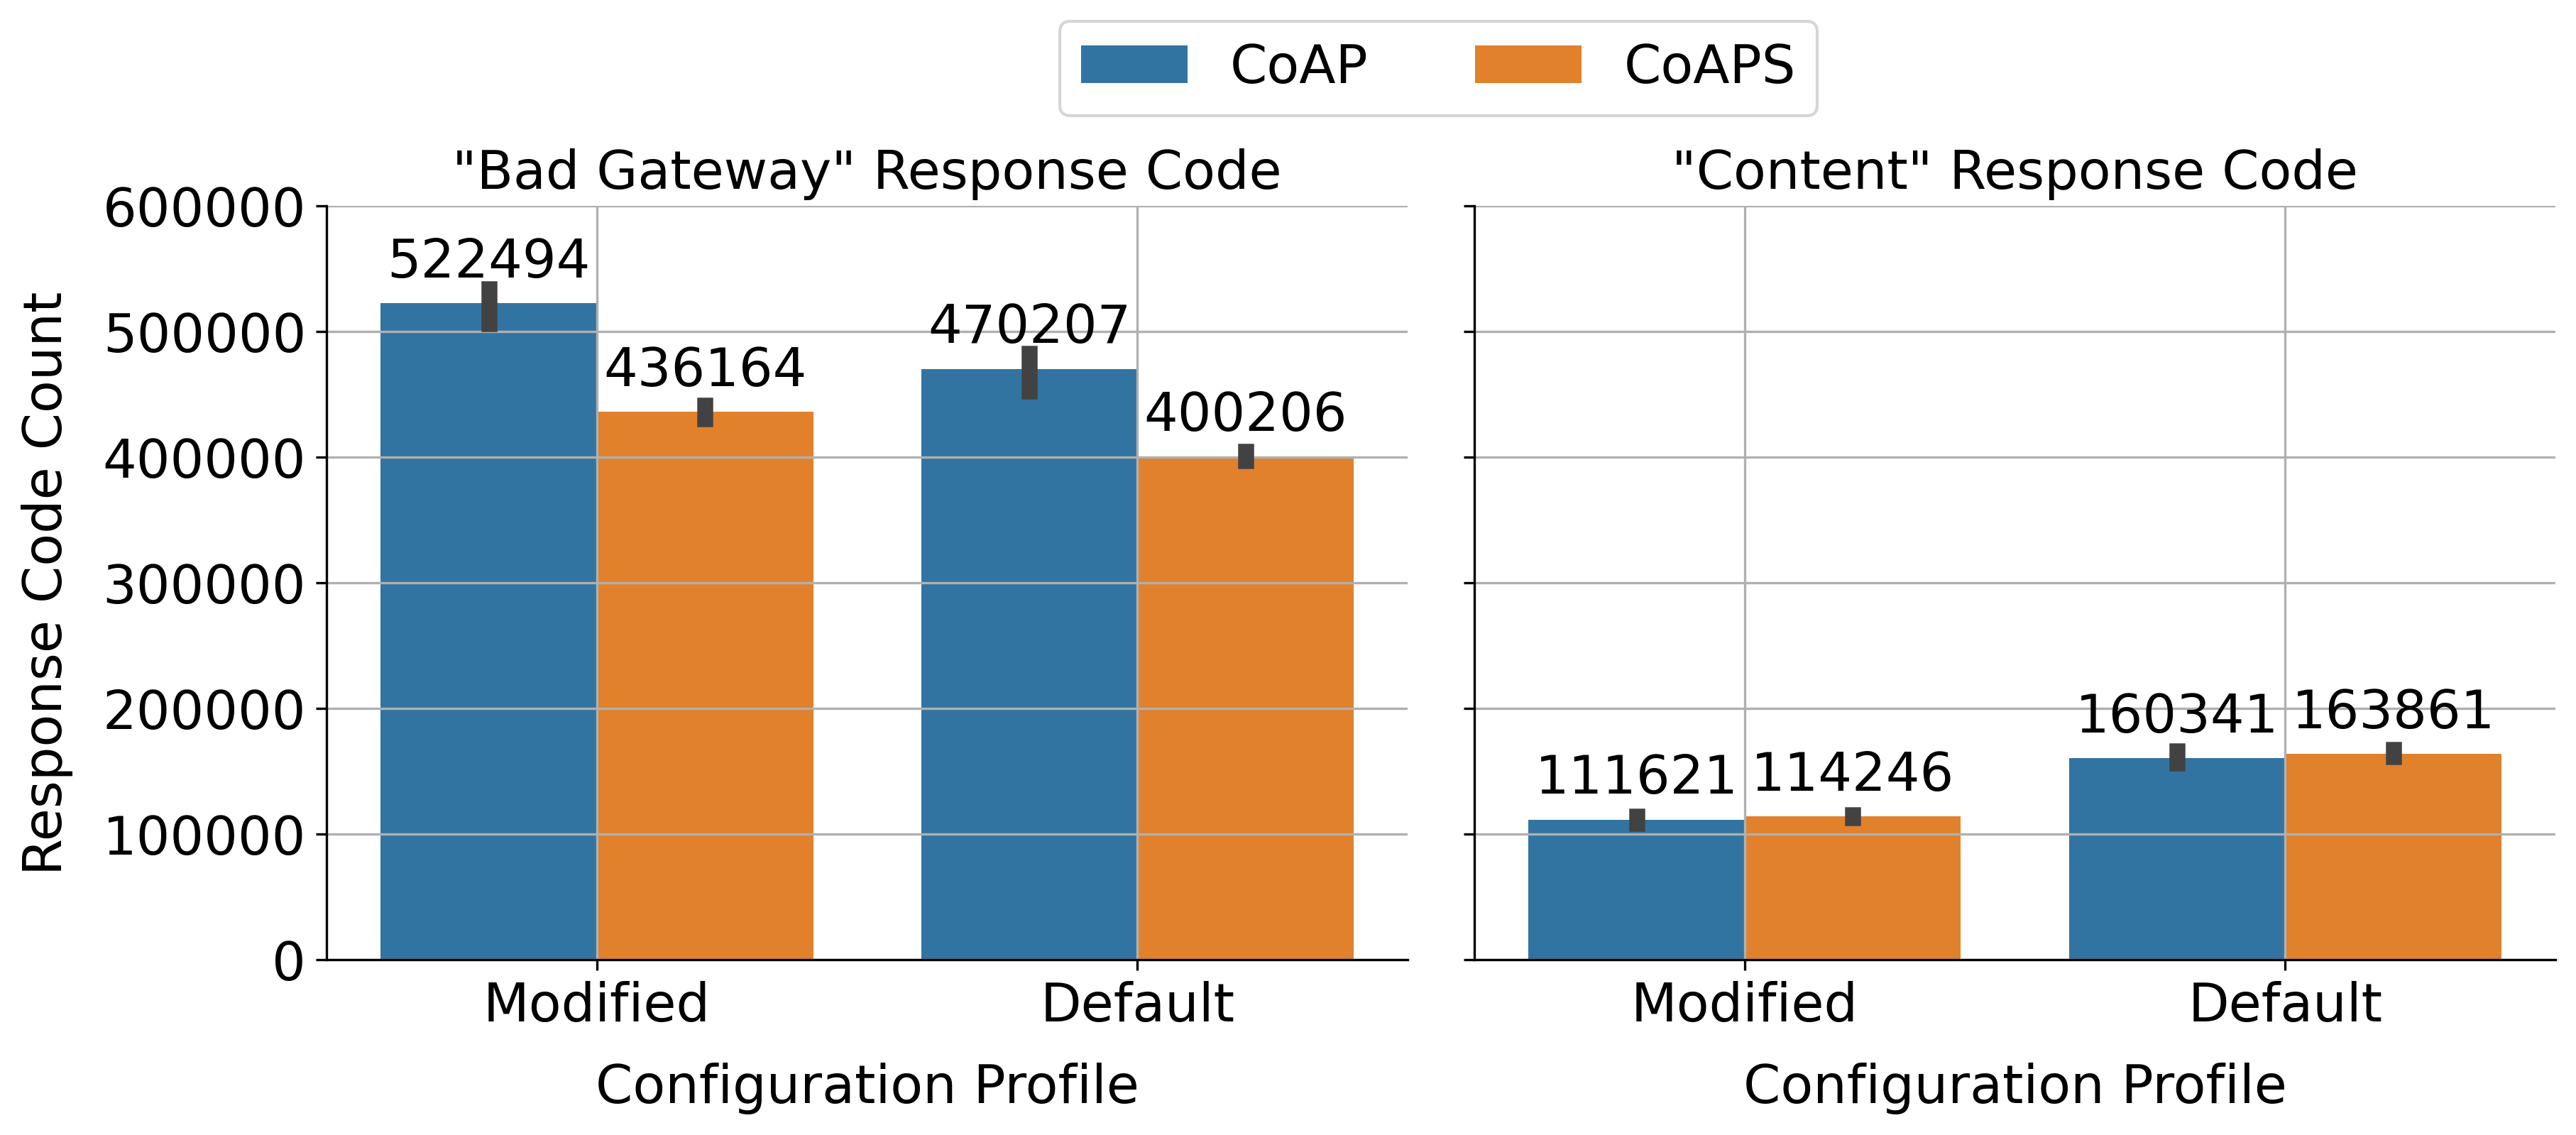

CPU times: user 1.47 s, sys: 167 ms, total: 1.64 s
Wall time: 1.32 s


response_code_count
Response Code Client Protocol configuration_profile                     
Bad Gateway   CoAP            Default                           470207.8
                              Modified                          522494.4
              CoAPS           Default                           400206.0
                              Modified                          436164.6
Content       CoAP            Default                           160341.2
                              Modified                          111621.6
              CoAPS           Default                           163861.8
                              Modified                          114246.8

In [66]:
%%time

df = (
  attacker_message_df
  .replace(value_map_replacement)
  .rename(columns={
    "response_code": "Response Code",
    "run_proxy_with_dtls": "Client Protocol",
  })
  .sort_values(by=["configuration_profile"], ascending=False)
)

g = sns.catplot(
  data=df,
  kind="bar",
  x="configuration_profile",
  y="response_code_count",
  hue="Client Protocol",
  col="Response Code",
  aspect=1.25,
)

g.set_xlabels("Configuration Profile", labelpad=10)
g.set_ylabels("Response Code Count", labelpad=10)
g.set(
  yticks=np.arange(0, 600_001, 100_000)
)
g.set_titles(
  template='"{col_name}" Response Code',
)

axes = [ g.axes[0, i] for i in range(2) ]
for ax in axes:
  ax.grid(True, axis="both")
  for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.49, 1.09),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

(
  df
  .groupby(
    by=["Response Code", "Client Protocol", "configuration_profile"]
  )
  .agg(
    response_code_count=("response_code_count", "mean")
  )
)